In [1]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import gsw
from datetime import datetime,date
import os as os
from matplotlib.gridspec import GridSpec
from numpy.fft import fft,fft2,fftfreq
from scipy.interpolate import interp2d
from sklearn.linear_model import LinearRegression
from scipy import fftpack
from tqdm import tqdm
from scipy.stats import linregress,norm
import dask as da
import xarray as xar
import glob as glob
from cartopy.crs import PlateCarree 
from cartopy.feature import COASTLINE as COASTLINE



In [2]:

#TEMPORAL COORDINATES

timemin=1961
timemax=1994
JULREF = (np.datetime64('1950-01-01')-np.datetime64('0000-01-01')).astype('timedelta64[D]').astype('float64')
Btime=([np.datetime64(str(yr)+'-'+str(mth).zfill(2)+'-15') for yr in range(timemin,timemax+1) for mth in range(1,13) ]) #-np.datetime64('0000-01-01')) #.astype('timedelta64[D]').astype('float64')
Na = len(Btime)
Jtime=np.asanyarray((Btime-np.datetime64('1950-01-01')).astype('timedelta64[D]').astype('float64'))




#LEARNING PERIOD
RC=xar.open_mfdataset('Pacific_OCCIPUT_Full2.nc').isel(depth=[0,1,2,3,4,5])
RC=RC.where(RC['time2'].dt.year>=1995,drop=True)
RC['TEMP_polyfit_coefficients'] = RC['TEMP_polyfit_coefficients'].isel(time=0)
RC['T_Climato'] = RC['T_Climato'].isel(time=0)
RC['S_Climato'] = RC['S_Climato'].isel(time=0)
RC['PSAL_polyfit_coefficients'] = RC['PSAL_polyfit_coefficients'].isel(time=0)
RC = RC.merge(((RC['TEMP'].groupby('time2.month')-RC['T_Climato'])-RC['TEMP_polyfit_coefficients'].sel(degree=0)-RC['time']*RC['TEMP_polyfit_coefficients'].sel(degree=1)).rename('TEMP_detrend')).merge(((RC['PSAL'].groupby('time2.month')-RC['S_Climato'])-RC['PSAL_polyfit_coefficients'].sel(degree=0)-RC['time']*RC['PSAL_polyfit_coefficients'].sel(degree=1)).rename('PSAL_detrend'))
Clim1=RC['TEMP_polyfit_coefficients'].sel(degree=0)+RC['time']*RC['TEMP_polyfit_coefficients'].sel(degree=1)
Clim2=RC['PSAL_polyfit_coefficients'].sel(degree=0)+RC['time']*RC['PSAL_polyfit_coefficients'].sel(degree=1)


#LOAD THERMODYNAMICAL COEFFICIENTS ALPHA AND BETA
Alphabet= xar.open_dataset('Pacific_OCCIPUT_Alphabeta_OCCIPUT.nc')


#GENERATE MEAN DENSITY
p = gsw.conversions.p_from_z(-RC['depth'], RC['latitude'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
SA = gsw.conversions.SA_from_SP(RC['PSAL'], p, RC['longitude'], RC['latitude'])
CT = gsw.conversions.CT_from_pt(SA, RC['TEMP'])
Rho0 =  gsw.density.rho(SA, CT, p).mean('time')



#TRUTH 
RC2=xar.open_mfdataset('Pacific_OCCIPUT_Full2.nc').isel(depth=[0,1,2,3,4,5])#.isel(depth=[0,3,4,5,6,7,8])
RC2=RC2.where(RC2['time2'].dt.year<1995,drop=True)
RC2 = RC2.drop('T_Climato')
RC2 = RC2.assign({'T_Climato':RC2['TEMP'].groupby('time2.month').mean()})
RC2 = RC2.drop('TEMP_polyfit_coefficients')
RC2 = RC2.merge((RC2['TEMP'].groupby('time2.month')-RC2['T_Climato']).polyfit('time',1).rename({'polyfit_coefficients':"TEMP_polyfit_coefficients"}))
RC2 = RC2.drop('S_Climato')
RC2 = RC2.assign({'S_Climato':RC2['PSAL'].groupby('time2.month').mean()})
RC2 = RC2.drop('PSAL_polyfit_coefficients')
RC2 = RC2.merge((RC2['PSAL'].groupby('time2.month')-RC2['S_Climato']).polyfit('time',1).rename({'polyfit_coefficients':"PSAL_polyfit_coefficients"}))

RC2 = RC2.merge(((RC2['TEMP'].groupby('time2.month')-RC2['T_Climato'])-RC2['TEMP_polyfit_coefficients'].sel(degree=0)-RC2['time']*RC2['TEMP_polyfit_coefficients'].sel(degree=1)).rename('TEMP_detrend')).merge(((RC2['PSAL'].groupby('time2.month')-RC2['S_Climato'])-RC2['PSAL_polyfit_coefficients'].sel(degree=0)-RC2['time']*RC2['PSAL_polyfit_coefficients'].sel(degree=1)).rename('PSAL_detrend'))
Rho_RC2 = Rho0.values[...,np.newaxis]+Rho0.values[...,np.newaxis]*(Alphabet['alpha'].mean('time')*-(RC2['TEMP'].groupby('time2.month')-RC['T_Climato'])+Alphabet['beta'].mean('time')*(RC2['PSAL'].groupby('time2.month')-RC['S_Climato']))




#SPATIAL COORDINATES

Nx = RC['longitude'].size
Ny = RC['latitude'].size
X,Y = np.meshgrid(RC['longitude'].compute(),RC['latitude'].compute(),indexing='xy')



    
#GENERATE CLIMATOLOGY

Clim=(RC['PSAL_polyfit_coefficients'].sel({'degree':0}).expand_dims({'Time':Jtime.size})+(Jtime)[:,np.newaxis,np.newaxis,np.newaxis]*RC['PSAL_polyfit_coefficients'].sel({'degree':1}).expand_dims({'Time':Jtime.size})).fillna(0).stack(NxNy=['latitude','longitude']).rename('Clim').assign_coords({'Time':Btime})
XbS = ((Clim*0).groupby('Time.month')+RC['S_Climato'].stack(NxNy=['latitude','longitude']).fillna(0)).reset_index('NxNy').compute()
Clim=(RC['TEMP_polyfit_coefficients'].sel({'degree':0}).expand_dims({'Time':Jtime.size})+(Jtime)[:,np.newaxis,np.newaxis,np.newaxis]*RC['TEMP_polyfit_coefficients'].sel({'degree':1}).expand_dims({'Time':Jtime.size})).fillna(0).stack(NxNy=['latitude','longitude']).rename('Clim').assign_coords({'Time':Btime})
XbT = ((Clim*0).groupby('Time.month')+RC['T_Climato'].stack(NxNy=['latitude','longitude']).fillna(0)).reset_index('NxNy').compute()
Xb = xar.concat((XbT.stack({"NxNyNz":['depth','NxNy']}),XbS.stack({"NxNyNz":['depth','NxNy']})),dim='NxNyNz')
Xb = xar.Dataset({'POTM':XbT,'PSAL':XbS})



#LOAD OBSERVATIONS

ENPSAL2 = xar.open_mfdataset(glob.glob('ENsal_NoInterp*NoFMoor_OCCIPUT.nc')[0]).isel(depth=[0,1,2,3,4,5])
for i in range(0,3):
    ENPSAL2= xar.concat((ENPSAL2,xar.open_mfdataset(glob.glob('ENsal_NoInterp*NoFMoor_OCCIPUT.nc')[1:][i]).isel(depth=[0,1,2,3,4,5])),'N_PROF')
    
ENtemp2 = xar.open_mfdataset(glob.glob('ENtemp_NoInterp*NoFMoor_OCCIPUT.nc')[0]).isel(depth=[0,1,2,3,4,5])#.isel(depth=[0,3,4,5,6,7,8])
for i in range(0,3):
    ENtemp2= xar.concat((ENtemp2,xar.open_mfdataset(glob.glob('ENtemp_NoInterp*NoFMoor_OCCIPUT.nc')[1:][i]).isel(depth=[0,1,2,3,4,5])),'N_PROF')
    
    
ENPSAL2=  ENPSAL2.where(ENPSAL2['PSAL']>=0)
ENtemp2=  ENtemp2.where(ENtemp2['POTM']>=0)
EN = xar.merge((ENtemp2.sortby('JULD'),ENPSAL2.sortby('JULD')))
EN = EN.where((EN['LONGITUDE']<RC['longitude'].max())&(EN['LONGITUDE']>RC['longitude'].min())&(EN['LATITUDE']<RC['latitude'].max())&(EN['LATITUDE']>RC['latitude'].min()),drop=True)

#ERROR OF REPRESENTATIVITY

Robs=xar.open_mfdataset('Robs_PSAL_OCCIPUT.nc').drop(('time','time2'))
Robs= Robs.where(Robs['PSAL_ERR']!=np.inf,np.nan)
Robs2=xar.open_mfdataset('Robs_TEMP_OCCIPUT.nc').drop(('time','time2'))
Robs2= Robs2.where(Robs2['POTM_ERR']!=np.inf,np.nan)

Robs = Robs.merge(Robs2)





#UnivarS and UnivarT
AnDA_sal2 = xar.open_dataset('UnivarS_14modes.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy') #redAnDA_PSAL_500_8modes_nointerp_RobsANDNonDiag20_005resitri_cutoff_OCCIPUT
AnDA_temp2= xar.load_dataset('UnivarT_14modes.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')

AnDA_sal3 = xar.open_dataset('UnivarS_40modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')
AnDA_temp3= xar.load_dataset('UnivarT_40modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy') #corrected version
Rho_AnDA3 =Rho0.values[...,np.newaxis]+Rho0.values[...,np.newaxis]*( Alphabet['alpha'].mean('time').rename({"latitude":"Lat","longitude":"Lon"})*-AnDA_temp3.coeff.dot(AnDA_temp3.functions)+Alphabet['beta'].mean('time').rename({"latitude":"Lat","longitude":"Lon"})*AnDA_sal3.coeff.dot(AnDA_sal3.functions))
Rho_AnDA2 =Rho0.values[...,np.newaxis]+Rho0.values[...,np.newaxis]*( Alphabet['alpha'].mean('time').rename({"latitude":"Lat","longitude":"Lon"})*-AnDA_temp2.coeff.dot(AnDA_temp2.functions)+Alphabet['beta'].mean('time').rename({"latitude":"Lat","longitude":"Lon"})*AnDA_sal2.coeff.dot(AnDA_sal2.functions))




#RedAndA TS
AnDA_TS5 = xar.load_dataset('redAnDA_T&S_40modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')
Rho_TS5 = Rho0.values[np.newaxis]+Rho0.values[np.newaxis]*(AnDA_TS5.coeff.dot(AnDA_TS5.functions).sum('var').values)
AnDA_TS5=AnDA_TS5.assign({'functions':AnDA_TS5.functions/xar.concat((-Alphabet.alpha.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'),(Alphabet.beta.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'))),'var')})
AnDA_TS5=AnDA_TS5.assign({'truncerr':AnDA_TS5.truncerr/xar.concat((Alphabet.alpha.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'),(Alphabet.beta.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'))),'var')})


AnDA_TS12 = xar.load_dataset('redAnDA_T&S_15modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')
Rho_TS12 = Rho0.values[np.newaxis]+Rho0.values[np.newaxis]*(AnDA_TS12.coeff.dot(AnDA_TS12.functions).sum('var'))
AnDA_TS12=AnDA_TS12.assign({'functions':AnDA_TS12.functions/xar.concat((-Alphabet.alpha.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'),(Alphabet.beta.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'))),'var')})
AnDA_TS12=AnDA_TS12.assign({'truncerr':AnDA_TS12.truncerr/xar.concat((Alphabet.alpha.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'),(Alphabet.beta.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'))),'var')})




# OPTIMAL INTERPOLATION
OI4 = xar.open_dataset('OI_TEMP_OCCIPUT.nc')
OI4_S = xar.open_dataset('OI_PSAL_OCCIPUT.nc')
Rho_OI = Rho0.values[...,np.newaxis]+Rho0.values[...,np.newaxis]*(Alphabet['alpha'].mean('time').rename({"latitude":"lat","longitude":"lon"})*-(OI4['values'].groupby('JULD.month')-RC['T_Climato'].rename({"latitude":"lat","longitude":"lon"}))+Alphabet['beta'].mean('time').rename({"latitude":"lat","longitude":"lon"})*(OI4_S['values'].groupby('JULD.month')-RC['S_Climato'].rename({"latitude":"lat","longitude":"lon"})))

#S-from-T
sujet = AnDA_temp3.coeff.dot(AnDA_temp3.functions)* -(Alphabet['alpha'].mean('time').fillna(0).rename({'latitude':'Lat','longitude':'Lon'}))
fcts = xar.load_dataset('redAnDA_T&S_40modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')['functions'].isel(modes=slice(0,AnDA_temp3.modes.size))
aclim = sujet.values.reshape((408,-1)).dot(np.swapaxes(fcts.values[0].reshape((6,40,-1)),0,1).reshape((40,-1)).T)
SfromT3 = xar.DataArray(aclim,dims=['time','modes']).dot(AnDA_TS5['functions'].isel(modes=slice(0,40)).isel(var=1)).assign_coords({"time":(['time'],AnDA_TS5['JULD'].values)})
Rho_SfromT3 = Rho0.values[np.newaxis]+Rho0.values[np.newaxis]*(sujet+Alphabet['beta'].mean('time').rename({"latitude":"Lat","longitude":"Lon"})*(SfromT3))


sujet = AnDA_temp2.coeff.dot(AnDA_temp2.functions)* -(Alphabet['alpha'].mean('time').fillna(0).rename({'latitude':'Lat','longitude':'Lon'}))
fcts = xar.load_dataset('redAnDA_T&S_15modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')['functions'].isel(modes=slice(0,AnDA_temp2.modes.size))
aclim = sujet.values.reshape((408,-1)).dot(np.swapaxes(fcts.values[0].reshape((6,AnDA_temp2.modes.size,-1)),0,1).reshape((AnDA_temp2.modes.size,-1)).T)
SfromT2 = xar.DataArray(aclim,dims=['time','modes']).dot(AnDA_TS12['functions'].isel(modes=slice(0,AnDA_temp2.modes.size)).isel(var=1)).assign_coords({"time":(['time'],AnDA_TS12['JULD'].values)})
Rho_SfromT2 = Rho0.values[np.newaxis]+Rho0.values[np.newaxis]*(sujet+Alphabet['beta'].mean('time').rename({"latitude":"Lat","longitude":"Lon"})*(SfromT2))





/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]


In [ ]:
print('Nbr Obs : \n West of 160°E : '+str(ENPSAL2.where(ENPSAL2.LONGITUDE<=160,drop=True).stack({'ALL':['depth','N_PROF']}).PSAL.dropna('ALL').size) +'\n East of 120°W : '+str(ENPSAL2.where(ENPSAL2.LONGITUDE>=360-120,drop=True).stack({'ALL':['depth','N_PROF']}).PSAL.dropna('ALL').size)+'\n In between :'+str(ENPSAL2.where(ENPSAL2.LONGITUDE>=160,drop=True).stack({'ALL':['depth','N_PROF']}).PSAL.dropna('ALL').size-ENPSAL2.where(ENPSAL2.LONGITUDE>=360-120,drop=True).stack({'ALL':['depth','N_PROF']}).PSAL.dropna('ALL').size))

Nbr Obs : 
 West of 160°E : 102892
 East of 120°W : 105570
 In between :84711


# CALCULATE NINO3.4 INDICES

In [3]:

lonmin,lonmax=-170+360,-120+360 #
latmin,latmax=-5,5 #
selectionNino = (RC['latitude']>=-5)&(RC['latitude']<=5)&(RC['longitude']>=-170+360)&(RC['longitude']<=-120+360)

ApprNino_T2 = AnDA_temp2['coeff'].dot(AnDA_temp2['functions'])[:,0,:,:].values[:,(RC['latitude']>=latmin)&(RC['latitude']<=latmax)][:,:,(RC['longitude']>=lonmin)&(RC['longitude']<=lonmax)].mean((1,2))
ApprNino_TS12 = AnDA_TS12['coeff'].dot(AnDA_TS12['functions'].sel(var=0))[:,0,:,:].values[:,(RC['latitude']>=latmin)&(RC['latitude']<=latmax)][:,:,(RC['longitude']>=lonmin)&(RC['longitude']<=lonmax)].mean((1,2))
ApprNino_OI = (OI4['values'].groupby('JULD.month')-OI4['values'].groupby('JULD.month').mean())[:,0,:,:].values[:,(RC['latitude']>=latmin)&(RC['latitude']<=latmax)][:,:,(RC['longitude']>=lonmin)&(RC['longitude']<=lonmax)].mean((1,2))
Nino = (RC2['TEMP_detrend'])[:,0,:,:].values[:,(RC['latitude']>=latmin)&(RC['latitude']<=latmax)][:,:,(RC['longitude']>=lonmin)&(RC['longitude']<=lonmax)].mean((1,2))


# GENERATE FIGURE 3

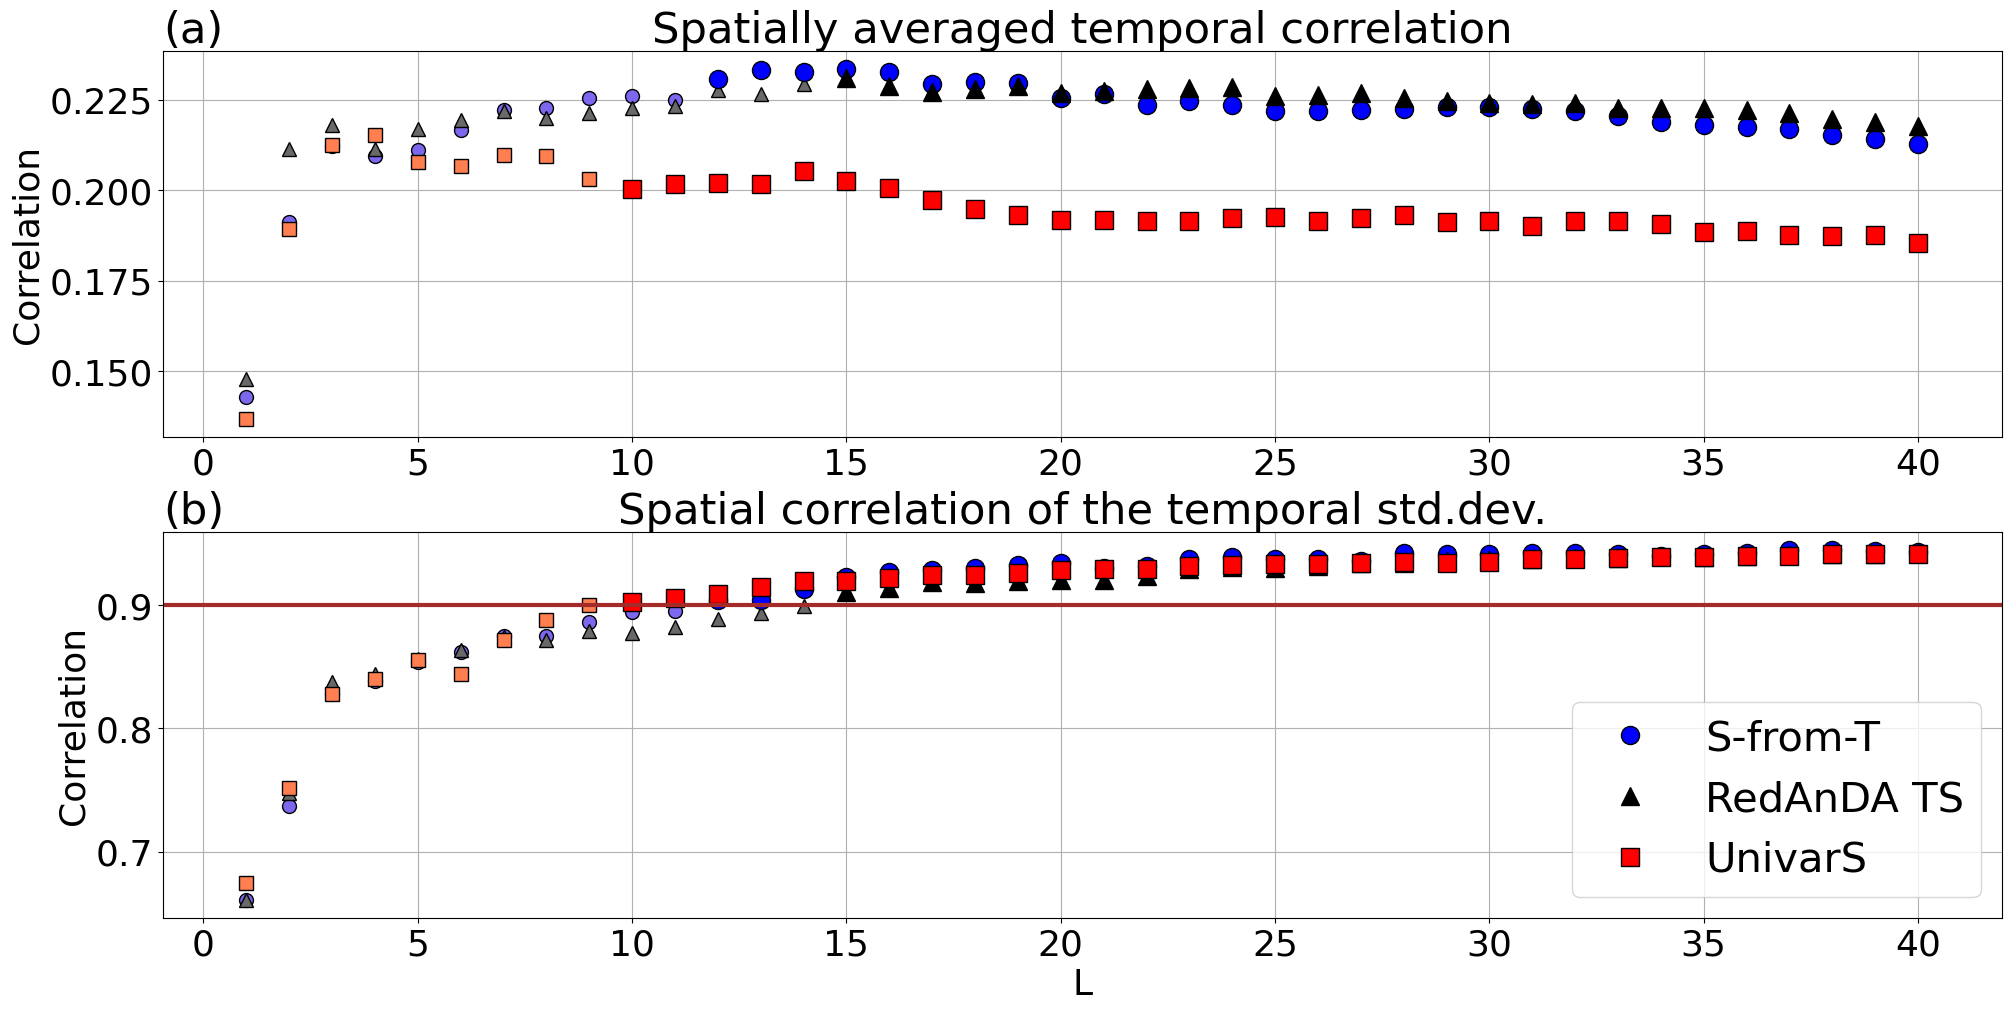

In [28]:
ts1v=[]
ts2v=[]

sa1v=[]
sa2v=[]

sft1v=[]
sft2v=[]

NxNy=RC['longitude'].size*RC['latitude'].size

truth2 = (RC2['PSAL'][-408:].groupby('time2.month')-RC['S_Climato'])

for modds in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
    
    redandatomap = AnDA_TS5.copy().isel(var=1).isel(modes=slice(0,modds))
    
    ts1v.append(np.nanmean(np.diag(np.corrcoef((redandatomap['coeff'].dot(redandatomap['functions'].fillna(0).isel(depth=slice(0,6))).values.reshape((408,-1))),(truth2[-408:].isel(depth=slice(0,6)).fillna(0).values.reshape((408,-1))),rowvar=False)[3*1904:,:3*1904])))
    ts2v.append(np.corrcoef(np.std(redandatomap['coeff'].dot(redandatomap['functions'].fillna(0).isel(depth=slice(0,6))).values.reshape((408,-1)),0),np.std(truth2[-408:].isel(depth=slice(0,6)).fillna(0).values.reshape((408,-1)),0),)[0,1])
    
    
    redandatomap = AnDA_sal3.copy().isel(modes=slice(0,modds))

    sa1v.append(np.nanmean(np.diag(np.corrcoef((redandatomap['coeff'].dot(redandatomap['functions'].fillna(0).isel(depth=slice(0,6))).values.reshape((408,-1))),(truth2[-408:].isel(depth=slice(0,6)).fillna(0).values.reshape((408,-1))),rowvar=False)[3*1904:,:3*1904])))
    sa2v.append(np.corrcoef(np.std(redandatomap['coeff'].dot(redandatomap['functions'].fillna(0).isel(depth=slice(0,6))).values.reshape((408,-1)),0),np.std(truth2[-408:].isel(depth=slice(0,6)).fillna(0).values.reshape((408,-1)),0),)[0,1])
   

    redandatomap = AnDA_sal3.copy().isel(modes=slice(0,modds))
    sujet = AnDA_temp3.coeff.isel(modes=slice(0,modds)).dot(AnDA_temp3.functions.isel(modes=slice(0,modds)))* -(Alphabet['alpha'].mean('time').fillna(0).rename({'latitude':'Lat','longitude':'Lon'}))
    fcts = xar.load_dataset('redAnDA_T&S_40modes_OCCIPUT.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy').isel(modes=slice(0,modds))['functions']
    aclim = sujet.values.reshape((408,-1)).dot(np.swapaxes(fcts.values[0].reshape((6,modds,-1)),0,1).reshape((modds,-1)).T)
    SfromT3 = xar.DataArray(aclim,dims=['time','modes']).dot(AnDA_TS5['functions'].isel(modes=slice(0,modds)).isel(var=1)).assign_coords({"time":(['time'],AnDA_TS5['JULD'].values)})

    
    sft1v.append(np.nanmean(np.diag(np.corrcoef((SfromT3.fillna(0).isel(depth=slice(0,6)).values.reshape((408,-1))),(truth2[-408:].isel(depth=slice(0,6)).fillna(0).values.reshape((408,-1))),rowvar=False)[3*1904:,:3*1904])))
    sft2v.append(np.corrcoef(np.std(SfromT3.fillna(0).isel(depth=slice(0,6)).values.reshape((408,-1)),0),np.std(truth2[-408:].isel(depth=slice(0,6)).fillna(0).values.reshape((408,-1)),0),)[0,1])
    
    
    NxNy=RC['longitude'].size*RC['latitude'].size

truth2 = (RC2['PSAL'][-408:].groupby('time2.month')-RC['S_Climato'])


matplotlib.rcParams.update({'font.size': 26})

import scipy.signal
b, a = scipy.signal.butter(5, 1/(24))

fig=plt.figure(constrained_layout=True,figsize=(20,10))


ax1 = fig.add_subplot(2,1,1)
ax1.set_xlabel('')
ax1.set_ylabel('Correlation')
# ax1.set_title('RedAnDA TS')
# ax11=ax1.twinx()


ax11 = fig.add_subplot(2,1,2)
ax11.set_xlabel('L')
ax1.set_title('Spatially averaged temporal correlation')
ax1.set_title('(a)', loc='left')
ax11.set_title('(b)', loc='left')
ax11.set_ylabel('Correlation')
# ax2.set_xlabel('')
# ax22=ax2.twinx()
ax11.set_title('Spatial correlation of the temporal std.dev.')


# ax3 = fig.add_subplot(3,1,3)
# ax3.set_xlabel('Time')
# ax3.set_ylabel('')
# ax3.set_title('S-from-T')
# ax3.set_xlabel('')
# ax33=ax3.twinx()

cs=['b','r','brown','k']
ind=0

marksiz=13

ax1.plot(np.arange(1,13,1),sft1v[:12],c='mediumslateblue',marker='o',markersize=marksiz-3,linewidth=5,linestyle='',markeredgecolor='k')
ax11.plot(np.arange(1,13,1),sft2v[:12],c='mediumslateblue',marker='o',markersize=marksiz-3,linewidth=5,linestyle='',markeredgecolor='k')
ax1.plot(np.arange(1,16,1),ts1v[:15],c='dimgrey',marker='^',markersize=marksiz-3,linewidth=5,linestyle='',markeredgecolor='k')
ax11.plot(np.arange(1,16,1),ts2v[:15],c='dimgrey',marker='^',markersize=marksiz-3,linewidth=5,linestyle='',markeredgecolor='k')
ax1.plot(np.arange(1,11,1),sa1v[:10],c='coral',marker='s',markersize=marksiz-3,linewidth=5,linestyle='',markeredgecolor='k')
ax11.plot(np.arange(1,11,1),sa2v[:10],c='coral',marker='s',markersize=marksiz-3,linewidth=5,linestyle='',markeredgecolor='k')

 
ax1.plot(np.arange(12,41,1),sft1v[11:],c='b',marker='o',markersize=marksiz,linewidth=5,linestyle='',markeredgecolor='k')
ax11.plot(np.arange(12,41,1),sft2v[11:],c='b',marker='o',markersize=marksiz,linewidth=5,linestyle='',markeredgecolor='k',label='S-from-T')

ax1.plot(np.arange(15,41,1),ts1v[14:],c='k',marker='^',markersize=marksiz,linewidth=5,linestyle='',markeredgecolor='k')
ax11.plot(np.arange(15,41,1),ts2v[14:],c='k',marker='^',markersize=marksiz,linewidth=5,linestyle='',markeredgecolor='k',label='RedAnDA TS')
ax1.plot(np.arange(10,41,1),sa1v[9:],c='r',marker='s',markersize=marksiz,linewidth=5,linestyle='',markeredgecolor='k')
ax11.plot(np.arange(10,41,1),sa2v[9:],c='r',marker='s',markersize=marksiz,linewidth=5,linestyle='',markeredgecolor='k',label='UnivarS')

 
ax1.grid()
ax11.grid()
    
ax11.legend(fontsize=30)
ax11.axhline(.9,linewidth=3,c='brown')
ax11.set_title('(b)',loc='left')
plt.savefig('../Article_SAL/OSSE_DetermineNbrEOFs2.png',format='png',transparent=True,bbox_inches='tight',dpi=300)

# ESTIMATE OPTIMIZED L VALUES AND GET THE RESULTING EXPLAINED VARIANCES

In [16]:
np.argmax(sft1v)

14

In [30]:
np.argmax(ts1v)

14

In [2]:
np.argmax(sa1v[9:]) #ADD 9

NameError: name 'np' is not defined

In [75]:
print('RedAnDA TS: ',ts1v[15],ts2v[15],'UnivarS ',sa1v[14],sa2v[14],'S-from-T: ',sft1v[15],sft2v[15])

RedAnDA TS:  0.22881483582485138 0.9134946391507089 UnivarS  0.20266182377962583 0.9196742998618339 S-from-T:  0.23279145863177853 0.926756447856608


# GENERATE FIGURE 4

/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 34 times more chunks
  return self.array[key]
/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 34 times more chunks
  return self.array[key]
/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 34 times more chunks
  return self.array[key]


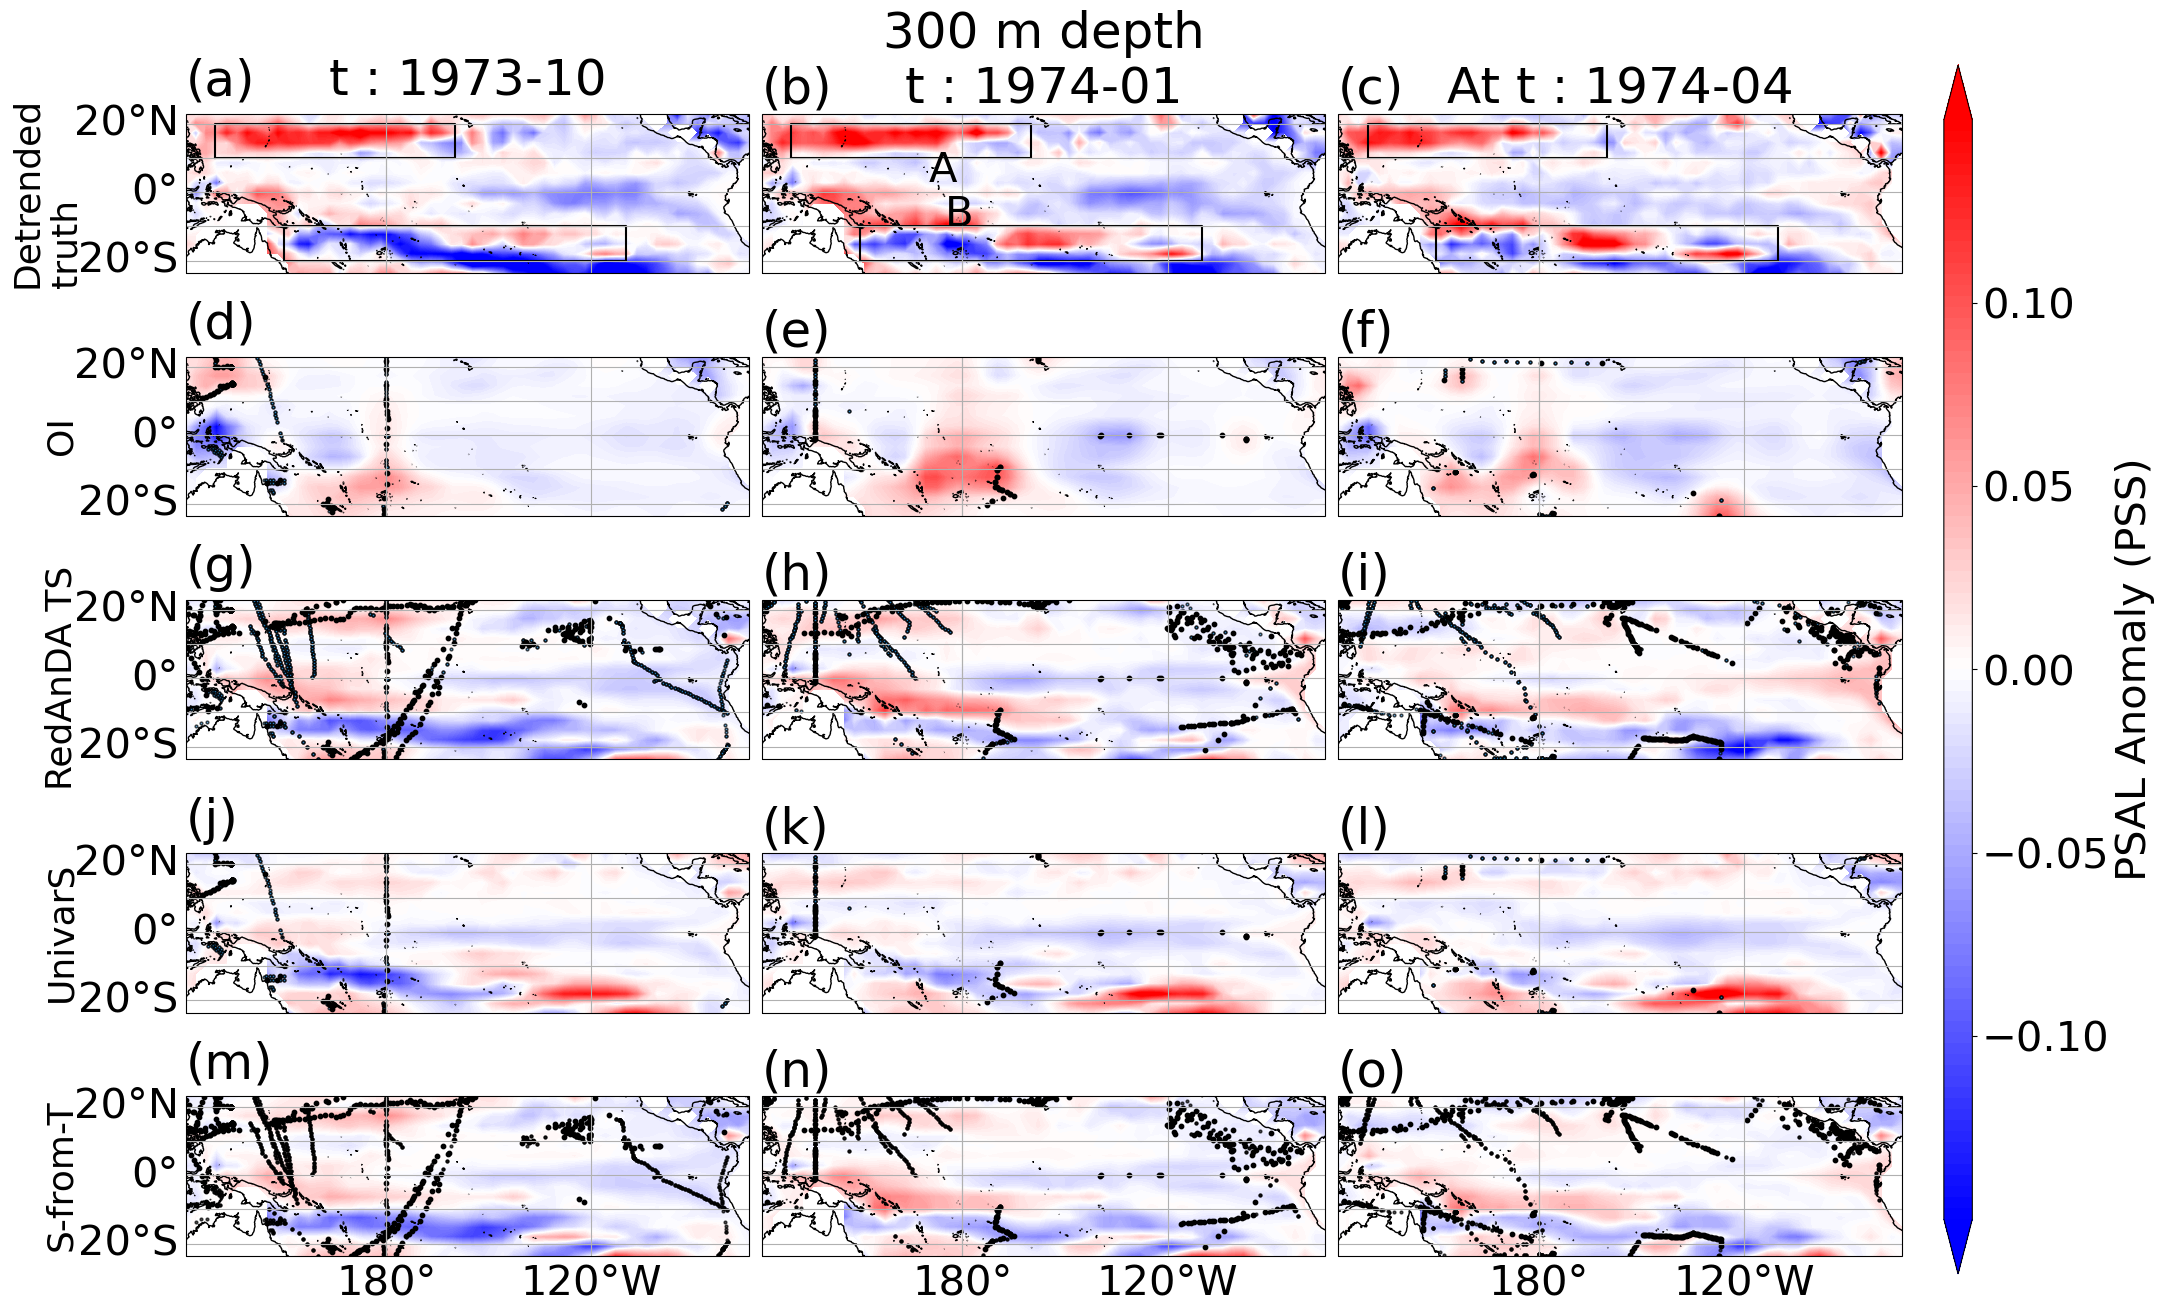

In [14]:
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.size': 30})
alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)','(q)','(r)','(s)','(t)','(u)','(v)']
alpind=0


fig = plt.figure(constrained_layout=True,figsize=(19,13),)

gs0 = gridspec.GridSpec(5, 3, figure=fig,hspace=0)

ax00 = fig.add_subplot(gs0[0,0],projection=PlateCarree(central_longitude=180))
ax01 = fig.add_subplot(gs0[0,1],projection=PlateCarree(central_longitude=180))
ax02 = fig.add_subplot(gs0[0,2],projection=PlateCarree(central_longitude=180))

ax10 = fig.add_subplot(gs0[1,0],projection=PlateCarree(central_longitude=180),sharex=ax00)
ax11 = fig.add_subplot(gs0[1,1],projection=PlateCarree(central_longitude=180),sharex=ax01)
ax12 = fig.add_subplot(gs0[1,2],projection=PlateCarree(central_longitude=180),sharex=ax02)

ax20 = fig.add_subplot(gs0[2,0],projection=PlateCarree(central_longitude=180),sharex=ax00)
ax21 = fig.add_subplot(gs0[2,1],projection=PlateCarree(central_longitude=180),sharex=ax01)
ax22 = fig.add_subplot(gs0[2,2],projection=PlateCarree(central_longitude=180),sharex=ax02)

ax30 = fig.add_subplot(gs0[3,0],projection=PlateCarree(central_longitude=180),sharex=ax00)
ax31 = fig.add_subplot(gs0[3,1],projection=PlateCarree(central_longitude=180),sharex=ax01)
ax32 = fig.add_subplot(gs0[3,2],projection=PlateCarree(central_longitude=180),sharex=ax02)

ax40 = fig.add_subplot(gs0[4,0],projection=PlateCarree(central_longitude=180),sharex=ax00)
ax41 = fig.add_subplot(gs0[4,1],projection=PlateCarree(central_longitude=180),sharex=ax01)
ax42 = fig.add_subplot(gs0[4,2],projection=PlateCarree(central_longitude=180),sharex=ax02)

for ax in [ax00,ax01,ax02,ax10,ax11,ax12,ax20,ax21,ax22,ax30,ax31,ax32,ax40,ax41,ax42]:

    ax.set_title(alphabet[alpind],loc='left')
    alpind+=1

dt=3
redandatomap = AnDA_TS12.copy().isel(var=1)#AnDA_TS6.isel(modes=slice(0,8)).copy().isel(var=1)
Xb2 = Xb['PSAL'].set_index({'NxNy':['latitude','longitude']}).unstack()
nEOF=redandatomap['modes'].size
oitomap = OI4_S.rename({"lat":"latitude","lon":"longitude"}).copy().where(RC2.PSAL.mean('time').notnull()).copy()


tim=180-12*2
ddepth=4
Thetime = Btime[-408:][tim]

mv =.15
lvls = np.arange(-mv,mv+mv/50,mv/50)

tim-=dt
time = Btime[-408:][tim]
ax20.contourf(np.unique(X)+180,np.unique(Y),redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull(),np.nan)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax10.contourf(np.unique(X)+180,np.unique(Y),(oitomap['values'].groupby('JULD.month')-oitomap['values'].groupby('JULD.month').mean()).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax30.contourf(np.unique(X)+180,np.unique(Y),AnDA_sal2['coeff'][-408:].dot(AnDA_sal2['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull(),np.nan)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax40.contourf(np.unique(X)+180,np.unique(Y),(SfromT2).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
# ax00.contourf(np.unique(X).compute()+180,np.unique(Y).compute(),(RC2['PSAL'][-408:]-Xb2.values).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax00.contourf(np.unique(X)+180,np.unique(Y),(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')

tim+=dt
time = Btime[-408:][tim]
ax21.contourf(np.unique(X)+180,np.unique(Y),redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull(),np.nan)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax11.contourf(np.unique(X)+180,np.unique(Y),(oitomap['values'].groupby('JULD.month')-oitomap['values'].groupby('JULD.month').mean()).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax31.contourf(np.unique(X)+180,np.unique(Y),AnDA_sal2['coeff'][-408:].dot(AnDA_sal2['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull(),np.nan)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax41.contourf(np.unique(X)+180,np.unique(Y),(SfromT2).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
# clmsh=ax01.contourf(np.unique(X).compute()+180,np.unique(Y).compute(),(RC2['PSAL'][-408:]-Xb2.values).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
clmsh=ax01.contourf(np.unique(X)+180,np.unique(Y),(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')

tim+=dt
time = Btime[-408:][tim]
ax22.contourf(np.unique(X)+180,np.unique(Y),redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull(),np.nan)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax12.contourf(np.unique(X)+180,np.unique(Y),(oitomap['values'].groupby('JULD.month')-oitomap['values'].groupby('JULD.month').mean()).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax32.contourf(np.unique(X)+180,np.unique(Y),AnDA_sal2['coeff'][-408:].dot(AnDA_sal2['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull(),np.nan)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax42.contourf(np.unique(X)+180,np.unique(Y),(SfromT2).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
# ax02.contourf(np.unique(X).compute()+180,np.unique(Y).compute(),(RC2['PSAL'][-408:]-Xb2.values).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')
ax02.contourf(np.unique(X)+180,np.unique(Y),(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth)[tim],vmin=-mv,vmax=mv,cmap=plt.cm.bwr,levels=lvls,extend='both')



for ti in range(0,3):
    time=Btime[-408:][tim-dt*2+dt*ti]
    
    mth_up=EN['JULD']<=(time+np.timedelta64(int(.5*30),'D'))
    mth_dwn=EN['JULD']>=(time-np.timedelta64(int(.5*30),'D'))
    _1990 = EN.where(mth_up&mth_dwn,drop=True).dropna('N_PROF','all')
    _1990 = _1990.where(_1990.LONGITUDE<=360-80,drop=True)

    for ax in [[ax20,ax21,ax22][ti]]:

        ax.scatter(_1990['LONGITUDE']+180,_1990['LATITUDE'],s=4,alpha=.7,ec='k',fc=None)

    _1990 = EN.where(mth_up&mth_dwn,drop=True).isel(depth=ddepth).dropna('N_PROF','all')
    _1990 = _1990.where(_1990.LONGITUDE<=360-80,drop=True)

    for ax in [[ax20,ax21,ax22][ti]]:

        ax.scatter(_1990['LONGITUDE']+180,_1990['LATITUDE'],s=10,c='k')

    mth_up=ENPSAL2['JULD']<=(time+np.timedelta64(int(.5*30),'D'))
    mth_dwn=ENPSAL2['JULD']>=(time-np.timedelta64(int(.5*30),'D'))
    _1990 = ENPSAL2.where(mth_up&mth_dwn,drop=True).dropna('N_PROF','all')
    _1990 = _1990.where(_1990.LONGITUDE<=360-80,drop=True)

    for ax in [[ax10,ax11,ax12][ti],[ax30,ax31,ax32][ti]]:

        ax.scatter(_1990['LONGITUDE']+180,_1990['LATITUDE'],s=4,alpha=.7,ec='k',fc=None)

    _1990 = ENPSAL2.where(mth_up&mth_dwn,drop=True).isel(depth=ddepth).dropna('N_PROF','all')
    _1990 = _1990.where(_1990.LONGITUDE<=360-80,drop=True)

    for ax in [[ax10,ax11,ax12][ti],[ax30,ax31,ax32][ti]]:

        ax.scatter(_1990['LONGITUDE']+180,_1990['LATITUDE'],s=10,c='k')

    mth_up=ENtemp2['JULD']<=(time+np.timedelta64(int(.5*30),'D'))
    mth_dwn=ENtemp2['JULD']>=(time-np.timedelta64(int(.5*30),'D'))
    _1990 =ENtemp2.where(mth_up&mth_dwn,drop=True).dropna('N_PROF','all')
    _1990 = _1990.where(_1990.LONGITUDE<=360-80,drop=True)

    for ax in [[ax40,ax41,ax42][ti]]:

        ax.scatter(_1990['LONGITUDE']+180,_1990['LATITUDE'],s=4,alpha=.7,c='k')

    _1990 =ENtemp2.where(mth_up&mth_dwn,drop=True).isel(depth=ddepth).dropna('N_PROF','all')
    _1990 = _1990.where(_1990.LONGITUDE<=360-80,drop=True)

    for ax in [[ax40,ax41,ax42][ti]]:

        ax.scatter(_1990['LONGITUDE']+180,_1990['LATITUDE'],s=10,c='k')



for axx in [ax00,ax01,ax02,ax10,ax11,ax12,ax20,ax21,ax22,ax30,ax31,ax32,ax40,ax41,ax42]:
    axx.add_feature(COASTLINE)
#     axx.add_feature(cfeature.LAND)
    axx.set_xlabel('Longitude (°E)')
    axx.set_ylabel('Latitude (°N)')

for axx in[ax01,ax02,ax11,ax12,ax21,ax22,ax31,ax32]:

    grdl=axx.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    grdl.right_labels=False
    grdl.bottom_labels=False
    grdl.left_labels=False
    grdl.top_labels=False


for axx in [ax00,ax10,ax20,ax30]:#,
    
    grdl=axx.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    grdl.right_labels=False
    grdl.bottom_labels=False
    grdl.top_labels=False

for axx in [ax41,ax42]: #[ax41,ax42]:
    
    grdl=axx.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    grdl.right_labels=False
    grdl.left_labels=False
    grdl.top_labels=False

    
    
lonmin,lonmax=130,200
latmin,latmax=10,20 #

ax00.plot([lonmin+180,lonmax+180,lonmax+180,lonmin+180,lonmin+180],[latmin,latmin,latmax,latmax,latmin], c='k', transform=PlateCarree(central_longitude=180))
ax01.plot([lonmin+180,lonmax+180,lonmax+180,lonmin+180,lonmin+180],[latmin,latmin,latmax,latmax,latmin], c='k', transform=PlateCarree(central_longitude=180))
ax02.plot([lonmin+180,lonmax+180,lonmax+180,lonmin+180,lonmin+180],[latmin,latmin,latmax,latmax,latmin], c='k', transform=PlateCarree(central_longitude=180))


lonmin,lonmax=150,250
latmin,latmax=-20,-10 #
ax00.plot([lonmin+180,lonmax+180,lonmax+180,lonmin+180,lonmin+180],[latmin,latmin,latmax,latmax,latmin], c='k', transform=PlateCarree(central_longitude=180))
ax01.plot([lonmin+180,lonmax+180,lonmax+180,lonmin+180,lonmin+180],[latmin,latmin,latmax,latmax,latmin], c='k', transform=PlateCarree(central_longitude=180))
ax02.plot([lonmin+180,lonmax+180,lonmax+180,lonmin+180,lonmin+180],[latmin,latmin,latmax,latmax,latmin], c='k', transform=PlateCarree(central_longitude=180))




# grdl=ax40.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl=ax40.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
ax00.set_title('t : '+str(Thetime.astype('datetime64[M]')-np.timedelta64(dt,'M')))

# -97,0, 'IAP',fontsize=22,rotation='vertical',va='center')
ax10.text(x=-3-97,y=0,s='OI',rotation=90,fontsize=26,va='center')
ax20.text(x=-3-97,y=0,s='RedAnDA TS',rotation=90,fontsize=26,va='center')
ax00.text(x=-3-107,y=0,s='Detrended\ntruth',rotation=90,fontsize=26,va='center')
ax30.text(x=-3-97,y=0,s='UnivarS',rotation=90,fontsize=26,va='center')
ax40.text(x=-3-97,y=0,s='S-from-T',rotation=90,fontsize=26,va='center')
# ax40.set_title('S from T at t-'+str(dt))

# ax21.set_title('At t')
# ax11.set_title('At t')
ax01.set_title('300 m depth\nt : '+str(Thetime.astype('datetime64[M]')))
# ax31.set_title('At t')
# ax41.set_title('At t')

# ax22.set_title('At t+'+str(dt))
# ax12.set_title('At t+'+str(dt))
ax02.set_title('At t : '+str(Thetime.astype('datetime64[M]')+np.timedelta64(dt,'M')))
# ax32.set_title('At t+'+str(dt))
# ax42.set_title('At t+'+str(dt))

plt.colorbar(clmsh,cax=plt.axes([1.02,.025,.015,.93]),orientation="vertical",ticks=[-.1,-.05,-0,.05,.1],aspect=40,fraction=0.2,pad=.05,label='PSAL Anomaly (PSS)')


ax01.text(-20+10,3,'A',fontsize=30)
ax01.text(-15+10,-10,'B',fontsize=30)
plt.savefig('../Article_SAL/PSALMaps_Depth'+str(ddepth)+'_Time'+str(tim)+'TS12.png',format='png',transparent=True,bbox_inches='tight',dpi=300)

# GENERATE FIGURE 5

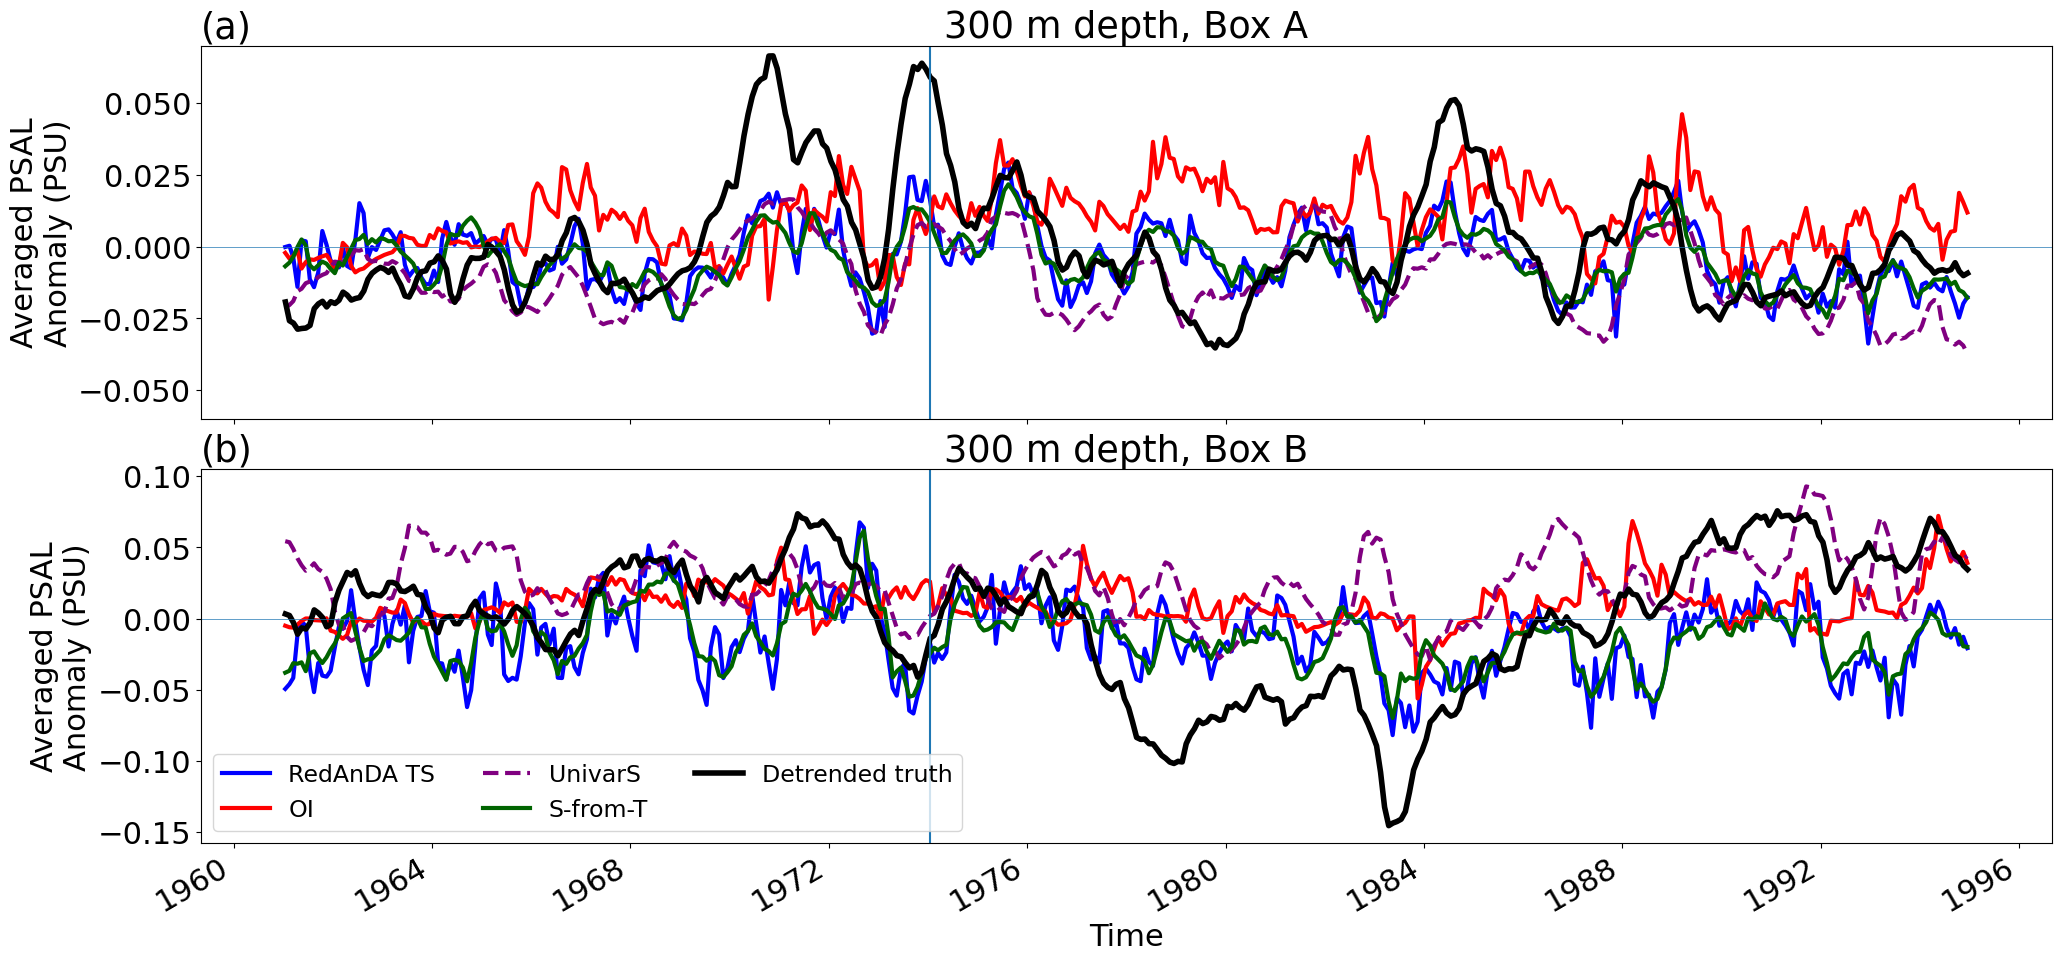

In [4]:
from cartopy.crs import PlateCarree 
matplotlib.rcParams.update({'font.size': 22})
alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)']
alpind=0


from cartopy.feature import COASTLINE as COASTLINE

import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True,figsize=(20.5,9.5),)

ax4 = fig.add_subplot(2,1,1)
ax5 = fig.add_subplot(2,1,2)

ax4.set_title(alphabet[alpind],loc='left')
alpind+=1
ax5.set_title(alphabet[alpind],loc='left')
alpind+=1


redandatomap = AnDA_TS12.copy().isel(var=1)#AnDA_TS6.isel(modes=slice(0,8)).copy().isel(var=1)
# redandatomap = redAnDA22.rename({'Depth':'depth'}).copy()

Xb2 = Xb['PSAL'].set_index({'NxNy':['latitude','longitude']}).unstack()

nEOF=redandatomap['modes'].size
# redoitomap = redOI3.rename({'Depth':'depth'}).set_index({"NxNy":['Lat','Lon']}).unstack()
# nEOF2=redoitomap['modes'].size
oitomap = OI4_S.rename({"lat":"latitude","lon":"longitude"}).copy()


tim=180-12*2
ddepth=4


lonmin,lonmax=130,200
latmin,latmax=10,20 #

# redandatomapp =( norm.interval(.5)[1]*UncertTS8.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*UncertTS8.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax4.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='blue')
redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).plot(ax=ax4,x='JULD',c='blue',label='RedAnDA TS',linewidth=3)

Bf = np.sqrt(oitomap['uncert'])
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
oitomapp =((oitomap['values']-Xb2.sortby('Time').values)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude'])
oitomapm =((oitomap['values']-Xb2.sortby('Time').values)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude'])
# ax4.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='red')
(oitomap['values']-Xb2.sortby('Time').values).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).plot(ax=ax4,x='JULD',c='red',label='OI',linewidth=3)


redandatomap = AnDA_sal2.copy()
# redandatomapp =(( norm.interval(.5)[1]*UncertSal2.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =(( -norm.interval(.5)[1]*UncertSal2.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapp =( norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]+norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]-norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax4.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='lightblue',linestyle='--')
redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).plot(ax=ax4,x='JULD',c='purple',linestyle='--',label='UnivarS',linewidth=3)


# Bf = SfromT_unc2
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
oitomapp =((SfromT2)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])

oitomapm =((SfromT2)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])
# ax4.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='green')
(SfromT2).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).plot(ax=ax4,x='time',c='darkgreen',label='SfromT',linewidth=3)


(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).plot(c='k',ax=ax4,x='time2',linewidth=4,label='Detrended truth')


# ax4.legend(fontsize=17,ncol=3,loc='lower right')
ax4.axvline(Btime[-408:][tim])
ax4.axhline(0,linewidth=.5)
ax4.set_xticklabels('')
ax4.set_xlabel('')
ax4.set_ylabel('Averaged PSAL\nAnomaly (PSU)')
ax4.set_title('300 m depth, Box A')
ax4.set_ylim(-.06,.07)





lonmin,lonmax=150,250
latmin,latmax=-20,-10 #
redandatomap = AnDA_TS12.copy().isel(var=1)#AnDA_TS6.isel(modes=slice(0,8)).copy().isel(var=1)

# redandatomapp =( norm.interval(.5)[1]*UncertTS8.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*UncertTS8.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax5.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='blue')
redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).plot(ax=ax5,x='JULD',c='blue',label='RedAnDA TS',linewidth=3)

# Bf = np.sqrt(oitomap['uncert'])
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
# oitomapp =((oitomap['values']-Xb2.sortby('Time').values)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude'])
# oitomapm =((oitomap['values']-Xb2.sortby('Time').values)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude'])
# ax5.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='red')
(oitomap['values']-Xb2.sortby('Time').values).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).plot(ax=ax5,x='JULD',c='red',label='OI',linewidth=3)


redandatomap = AnDA_sal2.copy()
# redandatomapp =(( norm.interval(.5)[1]*UncertSal2.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =(( -norm.interval(.5)[1]*UncertSal2.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapp =( norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]+norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]-norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax5.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='lightblue',linestyle='--')
redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).plot(ax=ax5,x='JULD',c='purple',linestyle='--',label='UnivarS',linewidth=3)


# Bf = SfromT_unc2
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
# oitomapp =((SfromT2)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])

# oitomapm =((SfromT2)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])
# ax5.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='green')
(SfromT2).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).plot(ax=ax5,x='time',c='darkgreen',label='S-from-T',linewidth=3)


(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).plot(c='k',ax=ax5,x='time2',linewidth=4,label='Detrended truth')


ax5.legend(fontsize=17,ncol=3,loc='lower left')
ax5.axvline(Btime[-408:][tim])
ax5.axhline(0,linewidth=.5)
ax5.set_xlabel('Time')
ax5.set_ylabel('Averaged PSAL\nAnomaly (PSU)')
ax5.set_title('300 m depth, Box B')
# ax5.set_ylim(-.2,.14)

plt.savefig('../Article_SAL/AveragedPSAL_Depth'+str(ddepth)+'TS12.png',format='png',transparent=True,bbox_inches='tight')

# CALCULATE THE CORRELATION SCORES OF THE SIGNALS FROM FIGURE 5

In [29]:

mask = RC.TEMP.mean('time').notnull()

redandatomap = AnDA_TS12.copy().isel(var=1)#AnDA_TS6.isel(modes=slice(0,8)).copy().isel(var=1)
# redandatomap = redAnDA22.rename({'Depth':'depth'}).copy()

Xb2 = Xb['PSAL'].set_index({'NxNy':['latitude','longitude']}).unstack()

nEOF=redandatomap['modes'].size
# redoitomap = redOI3.rename({'Depth':'depth'}).set_index({"NxNy":['Lat','Lon']}).unstack()
# nEOF2=redoitomap['modes'].size
oitomap = OI4_S.rename({"lat":"latitude","lon":"longitude"}).copy()


tim=180-12*2
ddepth=4


lonmin,lonmax=130,200
latmin,latmax=10,20 #

# redandatomapp =( norm.interval(.5)[1]*UncertTS3.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*UncertTS3.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax4.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='blue')
ano1=redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(mask.rename({'latitude':'Lat','longitude':'Lon'}).isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).values

ano2=(oitomap['values']-Xb2.sortby('Time').values).isel(depth=ddepth).where(mask.isel(depth=ddepth)).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).values

redandatomap = AnDA_sal2.copy()
# redandatomapp =(( norm.interval(.5)[1]*UncertSal.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =(( -norm.interval(.5)[1]*UncertSal.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapp =( norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]+norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]-norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax4.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='lightblue',linestyle='--')
ano3=redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(mask.rename({'latitude':'Lat','longitude':'Lon'}).isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).values


# Bf = SfromT_unc2
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
# oitomapp =((SfromT2)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])

# oitomapm =((SfromT2)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])
# ax4.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='green')
ano4=(SfromT2).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).values



anot=(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).values


print((np.corrcoef((anot,ano1))[0,1],np.corrcoef((anot,ano2))[0,1],np.corrcoef((anot,ano3))[0,1],np.corrcoef((anot,ano4))[0,1],))



lonmin,lonmax=150,250
latmin,latmax=-20,-10 #
redandatomap = AnDA_TS12.copy().isel(var=1)#AnDA_TS6.isel(modes=slice(0,8)).copy().isel(var=1)

# redandatomapp =( norm.interval(.5)[1]*UncertTS3.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*UncertTS3.isel(depth=ddepth,var=1)+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax5.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='blue')
ano1=redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(mask.rename({'latitude':'Lat','longitude':'Lon'}).isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).values

Bf = np.sqrt(oitomap['uncert'])
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
# oitomapp =((oitomap['values']-Xb2.sortby('Time').values)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude'])
# oitomapm =((oitomap['values']-Xb2.sortby('Time').values)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude'])
# ax5.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='red')
ano2=(oitomap['values']-Xb2.sortby('Time').values).isel(depth=ddepth).where(mask.isel(depth=ddepth)).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).values


redandatomap = AnDA_sal2.copy()
# redandatomapp =(( norm.interval(.5)[1]*UncertSal.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =(( -norm.interval(.5)[1]*UncertSal.isel(depth=ddepth))+(redandatomap['coeff'][-408:] ).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapp =( norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]+norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# redandatomapm =( -norm.interval(.5)[1]*truncerr[np.newaxis,:]+(redandatomap['coeff'][-408:]-norm.interval(.5)[1]*np.diagonal(np.sqrt(covanda2)[-408:],axis1=1,axis2=2)).dot(redandatomap.isel(depth=ddepth)['functions'])).where((redandatomap['Lat']>=latmin)&(redandatomap['Lat']<=latmax)&(redandatomap['Lon']>=lonmin)&(redandatomap['Lon']<=lonmax),drop=True).mean(['Lat','Lon'])#.rolling({'time':3},1).mean()
# ax5.fill_between(redandatomap['JULD'][-408:].values,redandatomapm,redandatomapp,alpha=.5,fc='lightblue',linestyle='--')
ano3=redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(depth=ddepth)).where(mask.rename({'latitude':'Lat','longitude':'Lon'}).isel(depth=ddepth)).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).values


# Bf = SfromT_unc2
# Bf = (oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*(Robs.rolling({'latitude':3,'longitude':3},center=True,min_periods=4).mean().where(Robs['PSAL_ERR'].notnull()))['PSAL_ERR']+(1-oitomap['PCTVAR'].where(oitomap['PCTVAR']<=1,1))*RC['PSAL_detrend'].fillna(0).std('time').values
# Bf = Bf.rename({"lat":"latitude","lon":"longitude"})
# oitomapp =((SfromT)+norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])

# oitomapm =((SfromT)-norm.interval(.5)[1]*Bf).isel(depth=ddepth).fillna(0).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon'])
# ax5.fill_between(redandatomap['JULD'][-408:].values,oitomapm,oitomapp,alpha=.5,fc='green')
ano4=(SfromT2).isel(depth=ddepth).sel({'Lat':slice(latmin,latmax),'Lon':slice(lonmin,lonmax)}).mean(['Lat','Lon']).values


anot=(RC2['PSAL_detrend'][-408:]).isel(depth=ddepth).sel({'latitude':slice(latmin,latmax),'longitude':slice(lonmin,lonmax)}).mean(['latitude','longitude']).values


# print((np.corrcoef((anot,ano1))[0,1],np.corrcoef((anot,ano2))[0,1],np.corrcoef((anot,ano3))[0,1],np.corrcoef((anot,ano4))[0,1]))
print((np.corrcoef((anot,ano1))[0,1],np.corrcoef((anot,ano2))[0,1],np.corrcoef((anot,ano3))[0,1],np.corrcoef((anot,ano4))[0,1]))




(0.6065065134865659, 0.10484224954393483, 0.6324576459567934, 0.5895351638322166)
(0.4243657558375795, 0.3037859234683147, 0.45500498377748844, 0.44353429861268645)


# CALCULATE THE CORRELATION SCORES AT MONTHLY SCALE

In [157]:

msk=RC2.isel(time=0).PSAL.notnull().values.flatten()
filtered = ((RC2['PSAL_detrend'][-408:].groupby('time2.month')+RC2.S_Climato))
filtered = (filtered).values.reshape((408,-1))[:,msk]

filtered4 =  ((OI4_S['values']))#.groupby('JULD.month')-OI4_S['values'].groupby('JULD.month').mean()).where(RC2['PSAL'].mean('time').rename({"latitude":"lat","longitude":"lon"}).notnull()))
filtered4 = (filtered4).values.reshape((408,-1))[:,msk]

filtered7 = ((AnDA_sal2.coeff.dot(AnDA_sal2.functions.where(AnDA_sal2.functions.notnull())))).groupby('JULD.month')+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered7 = (filtered7).values.reshape((408,-1))[:,msk]

filtered8 = (SfromT2).groupby('time.month')+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered8 = (filtered8).values.reshape((408,-1))[:,msk]

filtered12 =  ((AnDA_TS12.coeff.dot(AnDA_TS12.functions.isel(var=1)))).groupby('JULD.month')+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered12 = (filtered12).values.reshape((408,-1))[:,msk]



frstvec=filtered.reshape((-1,12,5396)).mean(0)

scdvec=filtered4.reshape((-1,12,5396)).mean(0)
print('OI :' +str(np.mean(np.diag(np.corrcoef(frstvec.T,scdvec.T)[5396:,:5396])) ))


scdvec=filtered7.reshape((-1,12,5396)).mean(0)
print('UnivarS : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,scdvec.T)[5396:,:5396])) ))

scdvec=filtered8.reshape((-1,12,5396)).mean(0)
print('SfromT : ' +str(np.mean(np.diag(np.corrcoef(frstvec.T,scdvec.T)[5396:,:5396])) ))

scdvec=filtered12.reshape((-1,12,5396)).mean(0)
print("RedAnDA TS 12 (7500):" + str(np.mean(np.diag(np.corrcoef(frstvec.T,scdvec.T)[5396:,:5396])) ))


/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 34 times more chunks
  return self.array[key]


OI :0.87459888231708
UnivarS : 0.8766161459554753
SfromT : 0.871763358204589
RedAnDA TS 12 (7500):0.8489424571771119


# CALCULATE THE CORRELATION SCORES AT DECADAL SCALE

In [159]:

msk=RC2.isel(time=0).PSAL.notnull().values.flatten()
filtered = ((RC2['PSAL'][-408:]))
filtered = (filtered).values.reshape((408,-1))[:,msk]

filtered4 =  ((OI4_S['values']).where(RC2['PSAL'].mean('time').rename({"latitude":"lat","longitude":"lon"}).notnull()))
filtered4 = (filtered4).values.reshape((408,-1))[:,msk]

filtered7 = ((AnDA_sal2.coeff.dot(AnDA_sal2.functions.where(AnDA_sal2.functions.notnull())))).groupby('JULD.month')+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered7 = (filtered7).values.reshape((408,-1))[:,msk]

filtered8 = (SfromT2).groupby('time.month')+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered8 = (filtered8).values.reshape((408,-1))[:,msk]

filtered12 =  ((AnDA_TS12.coeff.dot(AnDA_TS12.functions.isel(var=1)))).groupby('JULD.month')+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered12 = (filtered12).values.reshape((408,-1))[:,msk]



nbryr=10
frstvec=np.array([(filtered-filtered.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered.shape[0]-nbryr*12)])
frtvec=np.array([(filtered4-filtered4.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered4.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)
svtvec=np.array([(filtered7-filtered7.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered7.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)
eigthvec=np.array([(filtered8-filtered8.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered8.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)
vec12=np.array([(filtered12-filtered12.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered12.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)



print('OI : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,frtvec.T)[5396:,:5396])) ))
print('UnivarS : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,svtvec.T)[5396:,:5396])) ))
print('SfromT : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,eigthvec.T)[5396:,:5396])) ))
print('RedAnDA TS 12 : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,vec12.T)[5396:,:5396])) ))


OI : 0.007809291861821521
UnivarS : 0.11054326180669041
SfromT : 0.016651600622527185
RedAnDA TS 12 : 0.038484465801704885


In [160]:

msk=RC2.isel(time=0).PSAL.notnull().values.flatten()
filtered = ((RC2['PSAL_detrend'][-408:]))
filtered = (filtered).values.reshape((408,-1))[:,msk]

filtered4 =  ((OI4_S['values'].groupby('JULD.month')-OI4_S['values'].groupby('JULD.month').mean()).where(RC2['PSAL'].mean('time').rename({"latitude":"lat","longitude":"lon"}).notnull()))
filtered4 = (filtered4).values.reshape((408,-1))[:,msk]

filtered7 = ((AnDA_sal2.coeff.dot(AnDA_sal2.functions.where(AnDA_sal2.functions.notnull()))))#.groupby('JULD.month')#+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered7 = (filtered7).values.reshape((408,-1))[:,msk]

filtered8 = (SfromT2)#.groupby('time.month')#+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered8 = (filtered8).values.reshape((408,-1))[:,msk]

filtered12 =  ((AnDA_TS12.coeff.dot(AnDA_TS12.functions.isel(var=1))))#.groupby('JULD.month')#+RC.S_Climato.rename({'latitude':'Lat','longitude':'Lon'})
filtered12 = (filtered12).values.reshape((408,-1))[:,msk]



nbryr=10
frstvec=np.array([(filtered-filtered.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered.shape[0]-nbryr*12)])
frtvec=np.array([(filtered4-filtered4.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered4.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)
svtvec=np.array([(filtered7-filtered7.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered7.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)
eigthvec=np.array([(filtered8-filtered8.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered8.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)
vec12=np.array([(filtered12-filtered12.mean(0))[jj:jj+nbryr*12].mean(0) for jj in range(filtered12.shape[0]-nbryr*12)])#filtered2.reshape((-1,12,5396)).mean(1)



print('OI : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,frtvec.T)[5396:,:5396])) ))
print('UnivarS : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,svtvec.T)[5396:,:5396])) ))
print('SfromT : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,eigthvec.T)[5396:,:5396])) ))
print('RedAnDA TS 12 : '+str(np.mean(np.diag(np.corrcoef(frstvec.T,vec12.T)[5396:,:5396])) ))


OI : 0.03324400964250259
UnivarS : 0.10955426728703495
SfromT : 0.08599204919688681
RedAnDA TS 12 : 0.09382167056240642


# CALCULATE THE CORRELATION SCORES AT INTERANNUAL SCALE

In [161]:


filtered = ((RC2['PSAL_detrend'][-408:]))
# filtered = ((RC2['PSAL_detrend'][-408:].groupby('time2.month')-RC['S_Climato']))
filtered = np.ravel(filtered)

filtered4 =  ((OI4_S['values']-Xb2.sortby('Time').values).where(RC2['PSAL'].mean('time').rename({"latitude":"lat","longitude":"lon"}).notnull()))
filtered4 = np.ravel(filtered4)

filtered7 = ((AnDA_sal2.coeff.dot(AnDA_sal2.functions.where(AnDA_sal2.functions.notnull()))))
filtered7 = np.ravel(filtered7)

filtered8 = (SfromT2)
filtered8 = np.ravel(filtered8)


filtered11 =  ((AnDA_TS12.coeff.dot(AnDA_TS12.functions.isel(var=1))))
filtered11 = np.ravel(filtered11)





frstvec2=filtered.reshape((408,-1))[60:-60,msk]-frstvec

scdvec=filtered4.reshape((408,-1))[60:-60,msk]-frtvec
print("OI:"+str(np.mean(np.diag(np.corrcoef(frstvec2.T,scdvec.T)[5396:,:5396])) ))

scdvec=filtered7.reshape((408,-1))[60:-60,msk]-svtvec
print("UnivarS :" + str(np.mean(np.diag(np.corrcoef(frstvec2.T,scdvec.T)[5396:,:5396])) ))

scdvec=filtered8.reshape((408,-1))[60:-60,msk]-eigthvec
print("SfromT:" + str(np.mean(np.diag(np.corrcoef(frstvec2.T,scdvec.T)[5396:,:5396])) ))

scdvec=filtered11.reshape((408,-1))[60:-60,msk]-vec12
print("RedAnDA TS 12 (7500):" + str(np.mean(np.diag(np.corrcoef(frstvec2.T,scdvec.T)[5396:,:5396])) ))


OI:0.1196775019435404
UnivarS :0.2694657286739475
SfromT:0.31017823206252404
RedAnDA TS 12 (7500):0.3049797999876302


# OBSERVATION HISTOGRAM

In [47]:
salobs =EN.PSAL.stack({'ALL':['depth','N_PROF']}).dropna('ALL')
tempobs =EN.POTM.stack({'ALL':['depth','N_PROF']}).dropna('ALL')

<BarContainer object of 408 artists>

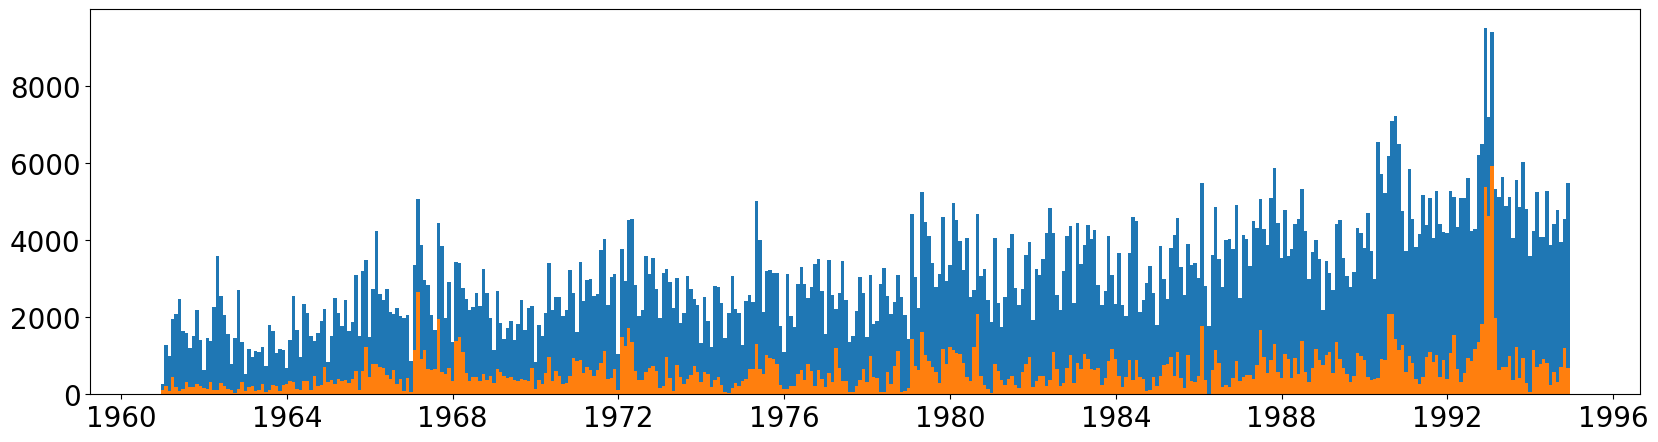

In [48]:
plt.figure(figsize=(20,5))
plt.hist(tempobs.JULD,bins=Btime)[-1]
plt.hist(salobs.JULD,bins=Btime)[-1]

# GENERATE FIGURE 6

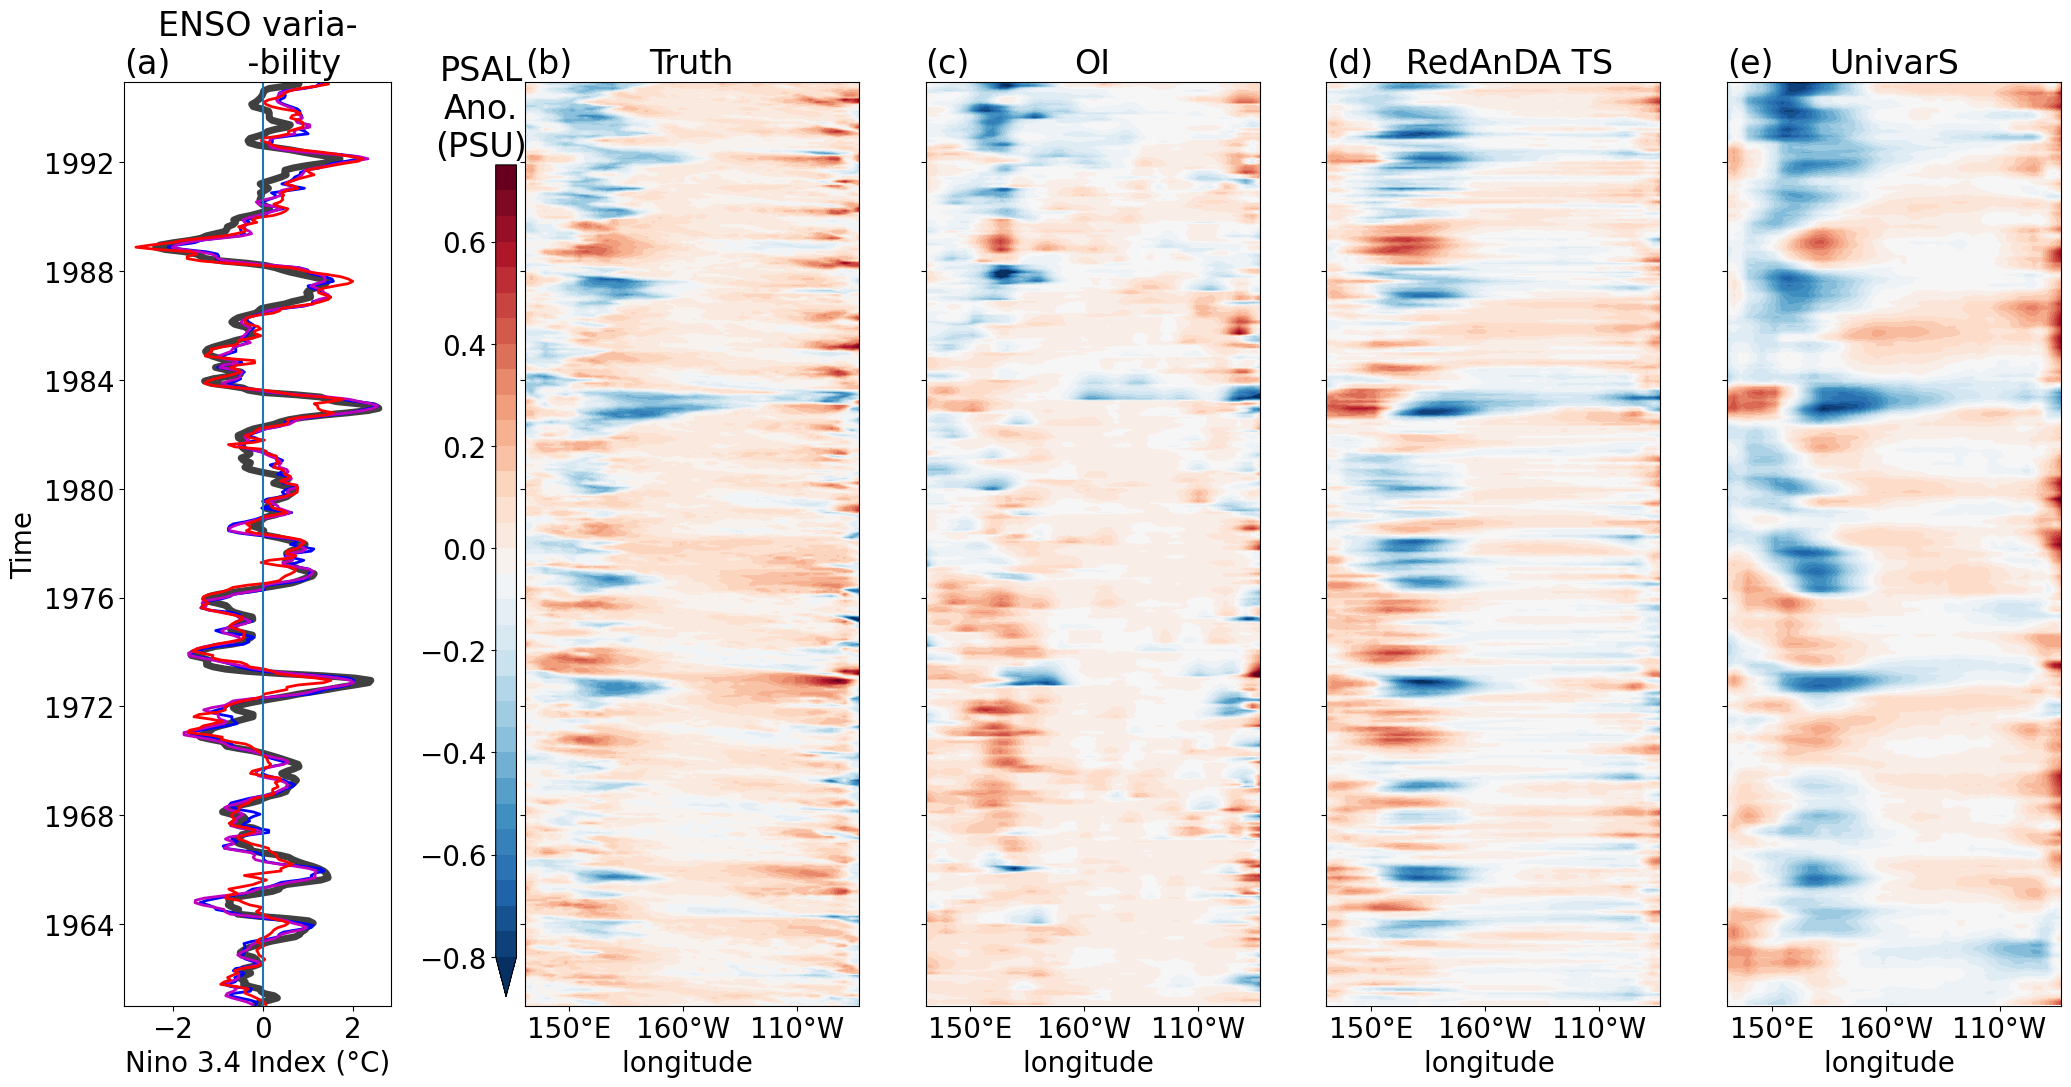

In [5]:
matplotlib.rcParams.update({'font.size': 20})
import scipy.signal as signal
fig = plt.figure(figsize=(25,12))
ddepth=0
alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)']
alpind=0




ax1=fig.add_subplot(1,5,1)
ax1.set_title(alphabet[alpind],loc='left')
alpind+=1

sos = signal.butter(3,1/(3), 'lowpass' ,fs=1,output='sos')

ax1.plot(signal.sosfiltfilt(sos,Nino[-408:]),AnDA_TS12['JULD'],c='k',linewidth=5,alpha=.75)
ax1.plot(signal.sosfiltfilt(sos,ApprNino_TS12[-408:]),AnDA_TS12['JULD'],c='b',linestyle='-',label='RedAnDA TS',linewidth=2)
ax1.plot(signal.sosfiltfilt(sos,ApprNino_T2[-408:]),AnDA_TS12['JULD'],c='m',linestyle='-',label='Univar RedAnDA',linewidth=2)

ax1.plot(signal.sosfiltfilt(sos,ApprNino_OI[-408:]),AnDA_TS12['JULD'],c='r',linestyle='-',label='OI',linewidth=2)
# ax1.set_xlim(-2.8,2.8)
ax1.set_ylim(np.datetime64('1961-01-01'),AnDA_TS12['JULD'].max())
ax1.axvline(0)
ax1.set_title('ENSO varia-\n       -bility' )
ax1.set_xlabel('Nino 3.4 Index (°C)' )

# ax1.legend()
ax1.set_ylabel('Time')

ax=fig.add_subplot(1,5,2)
ax.set_title(alphabet[alpind],loc='left')
alpind+=2

redandatomap = AnDA_TS12

ctrf=(RC2['PSAL'].groupby('time2.month')-RC['S_Climato'])[:].isel(depth=ddepth).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=np.arange(-.8,.8,.05),y='time2',add_colorbar=False)
# ctrf=(RC2['PSAL_detrend'])[:].isel(depth=ddepth).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=np.arange(-1,1,.05),y='time2',add_colorbar=False)


cbar=plt.colorbar(ctrf,ax=ax1,anchor=(3,0.1),aspect=40,shrink=.9)
cbar.ax.yaxis.tick_left()
cbar.ax.set_title('PSAL\nAno.\n(PSU)', x= -.7)

ax.set_xlabel('longitude ')
ax.set_title('Truth')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_ylim(np.datetime64('1961-01-01'),AnDA_TS12['JULD'].max())
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])

ax=fig.add_subplot(1,5,4,sharey=ax)
ax.set_title(alphabet[alpind],loc='left')
alpind+=1

(0*RC['S_Climato'].rename({"latitude":"Lat","longitude":"Lon"}).isel(depth=ddepth)+redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(var=1,depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull().values,np.nan).groupby('JULD.month')).sel({"Lon":slice(130,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contourf(levels=np.arange(-.8,.8,.05),extend='both',y='JULD',add_colorbar=False)

ax.set_ylabel('')
ax.set_xlabel('longitude ')
ax.set_title('   RedAnDA TS')
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])

ax=fig.add_subplot(1,5,5,sharey=ax)
ax.set_title(alphabet[alpind],loc='left')
alpind+=1

ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])


(0*RC['S_Climato'].rename({"latitude":"Lat","longitude":"Lon"}).isel(depth=ddepth)+AnDA_sal2['coeff'][-408:].dot(AnDA_sal2['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull().values,np.nan).groupby('JULD.month')).sel({"Lon":slice(130,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contourf(levels=np.arange(-.8,.8,.05),extend='both',y='JULD',add_colorbar=False)

ax.set_title('UnivarS')
ax.set_ylabel('')
ax.set_xlabel('longitude ')


ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])


# ax=fig.add_subplot(1,6,6,sharey=ax)
# ax.set_title(alphabet[alpind],loc='left')

# # (SfromT)[:].isel(depth=ddepth).sel({"Lon":slice(130,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contourf(levels=np.arange(-1,1,.05),extend='both',y='time',add_colorbar=False)

# ax.set_ylabel('')
# ax.set_xlabel('longitude (°E)')

# ax.set_title(" S from T")



ax=fig.add_subplot(1,5,3,sharey=ax)
alpind=2
ax.set_title(alphabet[alpind],loc='left')
oitomap = OI4_S.rename({"lat":"latitude","lon":"longitude"}).copy().where(RC['PSAL'][0,ddepth].notnull().values,np.nan)

((oitomap['values'].groupby('JULD.month')-oitomap['values'].groupby('JULD.month').mean()).isel(depth=0).where(RC['PSAL'][0,ddepth].notnull().values,np.nan)).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=np.arange(-.8,.8,.05),y='JULD',extend='both',add_colorbar=False)
# ((oitomap['values'].groupby('JULD.month')-RC['S_Climato']).isel(depth=0).where(RC['PSAL'][0,ddepth].notnull().values,np.nan)).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=np.arange(-.8,.8,.05),y='JULD',extend='both',add_colorbar=False)
ax.set_ylabel('')
ax.set_title('OI')
ax.set_xlabel('longitude ')

ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])

# plt.savefig('Article_SAL/Nino&SalinityFront_redandaTS3.png',format='png')
plt.savefig('../Article_SAL/Nino&SalinityFront_redandaTS12.png',format='png',dpi=300)


# CORRELATION SCORES OF THE DIFFERENT PRODUCTS WITH THE TRUTH, AT THE SURFACE, FOR THE WHOLE BASIN, THEN IN THE WESTERN TROPICAL PACIFIC THEN THE EASTERN TROPICAL PACIFIC

In [21]:



ddepth=0



redandatomap = AnDA_TS12

Sano=(RC2['PSAL'].groupby('time2.month')-RC['S_Climato'])[:].isel(depth=ddepth).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).values


Sano1=(0*RC['S_Climato'].rename({"latitude":"Lat","longitude":"Lon"}).isel(depth=ddepth)+redandatomap['coeff'][-408:].dot(redandatomap['functions'].isel(var=1,depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull().values,np.nan).groupby('JULD.month')).sel({"Lon":slice(130,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).values


Sano2=(0*RC['S_Climato'].rename({"latitude":"Lat","longitude":"Lon"}).isel(depth=ddepth)+AnDA_sal2['coeff'][-408:].dot(AnDA_sal2['functions'].isel(depth=ddepth)).where(RC['PSAL'].rename({"latitude":"Lat","longitude":"Lon"})[0,ddepth].notnull().values,np.nan).groupby('JULD.month')).sel({"Lon":slice(130,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).values


oitomap = OI4_S.rename({"lat":"latitude","lon":"longitude"}).copy().where(RC['PSAL'][0,ddepth].notnull().values,np.nan)

Sano3=((oitomap['values'].groupby('JULD.month')-oitomap['values'].groupby('JULD.month').mean()).isel(depth=0).where(RC['PSAL'][0,ddepth].notnull().values,np.nan)).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).values
Sano4=((SfromT2).isel(depth=0).where(RC['PSAL'][0,ddepth].notnull().values,np.nan)).sel({"Lon":slice(130,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).values
print(np.mean(np.diag(np.corrcoef(Sano[-408:],Sano1,rowvar=False)[50:,:50])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano2,rowvar=False)[50:,:50])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano3,rowvar=False)[50:,:50])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano4,rowvar=False)[50:,:50])),)

0.42576981368597083 0.40741547580709747 0.26489703079497423 0.41204259224077966


In [22]:
lind=27
print(np.mean(np.diag(np.corrcoef(Sano[-408:],Sano1,rowvar=False)[50:50+lind,:lind])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano2,rowvar=False)[50:50+lind,:lind])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano3,rowvar=False)[50:50+lind,:lind])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano4,rowvar=False)[50:50+lind,:lind])),)


0.5434071008709341 0.5015968521452555 0.315011554362538 0.5330712746310668


In [23]:
lind=27
print(np.mean(np.diag(np.corrcoef(Sano[-408:],Sano1,rowvar=False)[50+lind:,lind:50])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano2,rowvar=False)[50+lind:,lind:50])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano3,rowvar=False)[50+lind:,lind:50])),np.mean(np.diag(np.corrcoef(Sano[-408:],Sano4,rowvar=False)[50+lind:,lind:50])),)


0.2876738678601444 0.2968547296709989 0.20606693791131234 0.26996544334783396


# ESTIMATE OF STRATIFICATION, THE OSS+ AND OSS- 

In [24]:
g=9.81



Temp = RC2['TEMP_detrend'].groupby('time2.month')+RC2['T_Climato']
Psal =  RC2['PSAL_detrend'].groupby('time2.month')+ RC2['S_Climato']
N_RC2det= -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude')-Alphabet['beta'].mean('time').values*(Psal).differentiate('depth').transpose('time','depth','latitude','longitude'))
NT_RC2det = -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude'))
NS_RC2det = N_RC2det-NT_RC2det
# OSS_RC2det = np.where(np.nanmean(NS_RC2det,1)>0,np.nanmean(NS_RC2det,1),np.nan)
# OSSU_RC2det =  np.where(np.nanmean(NS_RC2det,1)<0,np.nanmean(NS_RC2det,1),np.nan)
OSS_RC2det = np.nanmean(np.where(NS_RC2det>0,NS_RC2det,np.nan),1)
OSSU_RC2det =  np.nanmean(np.where(NS_RC2det<0,NS_RC2det,np.nan),1)



Temp = RC2['TEMP']
Psal =  RC2['PSAL']
N_RC2= -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude')-Alphabet['beta'].mean('time').values*(Psal).differentiate('depth').transpose('time','depth','latitude','longitude'))
NT_RC2 = -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude'))
NS_RC2 = N_RC2-NT_RC2
OSS_RC2 = np.nanmean(np.where(NS_RC2>0,NS_RC2,np.nan),1)
OSSU_RC2 =  np.nanmean(np.where(NS_RC2<0,NS_RC2,np.nan),1)


Temp = (AnDA_temp2.coeff.dot(AnDA_temp2.functions.rename({"Lat":"latitude","Lon":"longitude"})).groupby('JULD.month')+RC['T_Climato']).rename({"JULD":'time'})
Psal = (SfromT2.rename({"Lat":"latitude","Lon":"longitude"}).groupby('time.month')+RC['S_Climato'])
N_SfromT= -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude')-Alphabet['beta'].mean('time').values*(Psal).differentiate('depth').transpose('time','depth','latitude','longitude'))
NT_SfromT = -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude'))
NS_SfromT = N_SfromT-NT_SfromT
OSS_SfromT = np.nanmean(np.where(NS_SfromT>0,NS_SfromT,np.nan),1)
OSSU_SfromT =  np.nanmean(np.where(NS_SfromT<0,NS_SfromT,np.nan),1)



Temp = (AnDA_temp2.coeff.dot(AnDA_temp2.functions.rename({"Lat":"latitude","Lon":"longitude"})).groupby('JULD.month')+RC['T_Climato']).rename({"JULD":'time'})
Psal = (AnDA_sal2.coeff.dot(AnDA_sal2.functions.rename({"Lat":"latitude","Lon":"longitude"})).groupby('JULD.month')+RC['S_Climato']).rename({"JULD":'time'})
N_AnDA2= -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude')-Alphabet['beta'].mean('time').values*(Psal).differentiate('depth').transpose('time','depth','latitude','longitude'))
NT_AnDA2 = -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude'))
NS_AnDA2 = N_AnDA2-NT_AnDA2
OSS_AnDA2 = np.nanmean(np.where(NS_AnDA2>0,NS_AnDA2,np.nan),1)
OSSU_AnDA2 =  np.nanmean(np.where(NS_AnDA2<0,NS_AnDA2,np.nan),1)





Temp = (OI4['values']).rename({"JULD":'time','lat':'latitude','lon':'longitude'})
Psal = (OI4_S['values']).rename({"JULD":'time','lat':'latitude','lon':'longitude'})
N_OI= -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude')-Alphabet['beta'].mean('time').values*(Psal).differentiate('depth').transpose('time','depth','latitude','longitude'))
NT_OI = -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude'))
NS_OI = N_OI-NT_OI
OSS_OI = np.nanmean(np.where(NS_OI>0,NS_OI,np.nan),1)
OSSU_OI =  np.nanmean(np.where(NS_OI<0,NS_OI,np.nan),1)

Temp = (AnDA_TS12.coeff.dot(AnDA_TS12.functions.isel(var=0).rename({"Lat":"latitude","Lon":"longitude"})).groupby('JULD.month')+RC['T_Climato']).rename({"JULD":'time'})
Psal = (AnDA_TS12.coeff.dot(AnDA_TS12.functions.isel(var=1).rename({"Lat":"latitude","Lon":"longitude"})).groupby('JULD.month')+RC['S_Climato']).rename({"JULD":'time'})
N_TS12= -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude')-Alphabet['beta'].mean('time').values*(Psal).differentiate('depth').transpose('time','depth','latitude','longitude'))
NT_TS12 = -g*(Alphabet['alpha'].mean('time').values*(Temp).differentiate('depth').transpose('time','depth','latitude','longitude'))
NS_TS12 = N_TS12-NT_TS12
OSS_TS12 = np.nanmean(np.where(NS_TS12>0,NS_TS12,np.nan),1)
OSSU_TS12 =  np.nanmean(np.where(NS_TS12<0,NS_TS12,np.nan),1)

/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/tmp/ipykernel_2529645/3734827962.py:12: RuntimeWarning: Mean of empty slice
  OSS_RC2det = np.nanmean(np.where(NS_RC2det>0,NS_RC2det,np.nan),1)
/tmp/ipykernel_2529645/3734827962.py:13: RuntimeWarning: Mean of empty slice
  OSSU_RC2det =  np.nanmean(np.where(NS_RC2det<0,NS_RC2det,np.nan),1)
/tmp/ipykernel_2529645/3734827962.py:22: RuntimeWarning: Mean of empty slice
  OSS_RC2 = np.nanmean(np.where(NS_RC2>0,NS_RC2,np.nan),1)
/tmp/ipykernel_2529645/3734827962.py:23: RuntimeWarning: Mean of empty slice
  OSSU_RC2 =  np.nanmean(np.where(NS_RC2<0,NS_RC2,np.nan),1)
/tmp/ipyke

# GENERATE FIGURE 7

/tmp/ipykernel_2529645/4260749061.py:56: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ctrf=ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(oicorr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
/tmp/ipykernel_2529645/4260749061.py:71: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(AnDAcorr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
/tmp/ipykernel_2529645/4260749061.py:85: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(TS3corr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
/tmp/ipykernel_2529645/4260749061.py:100: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(SfromTcorr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)


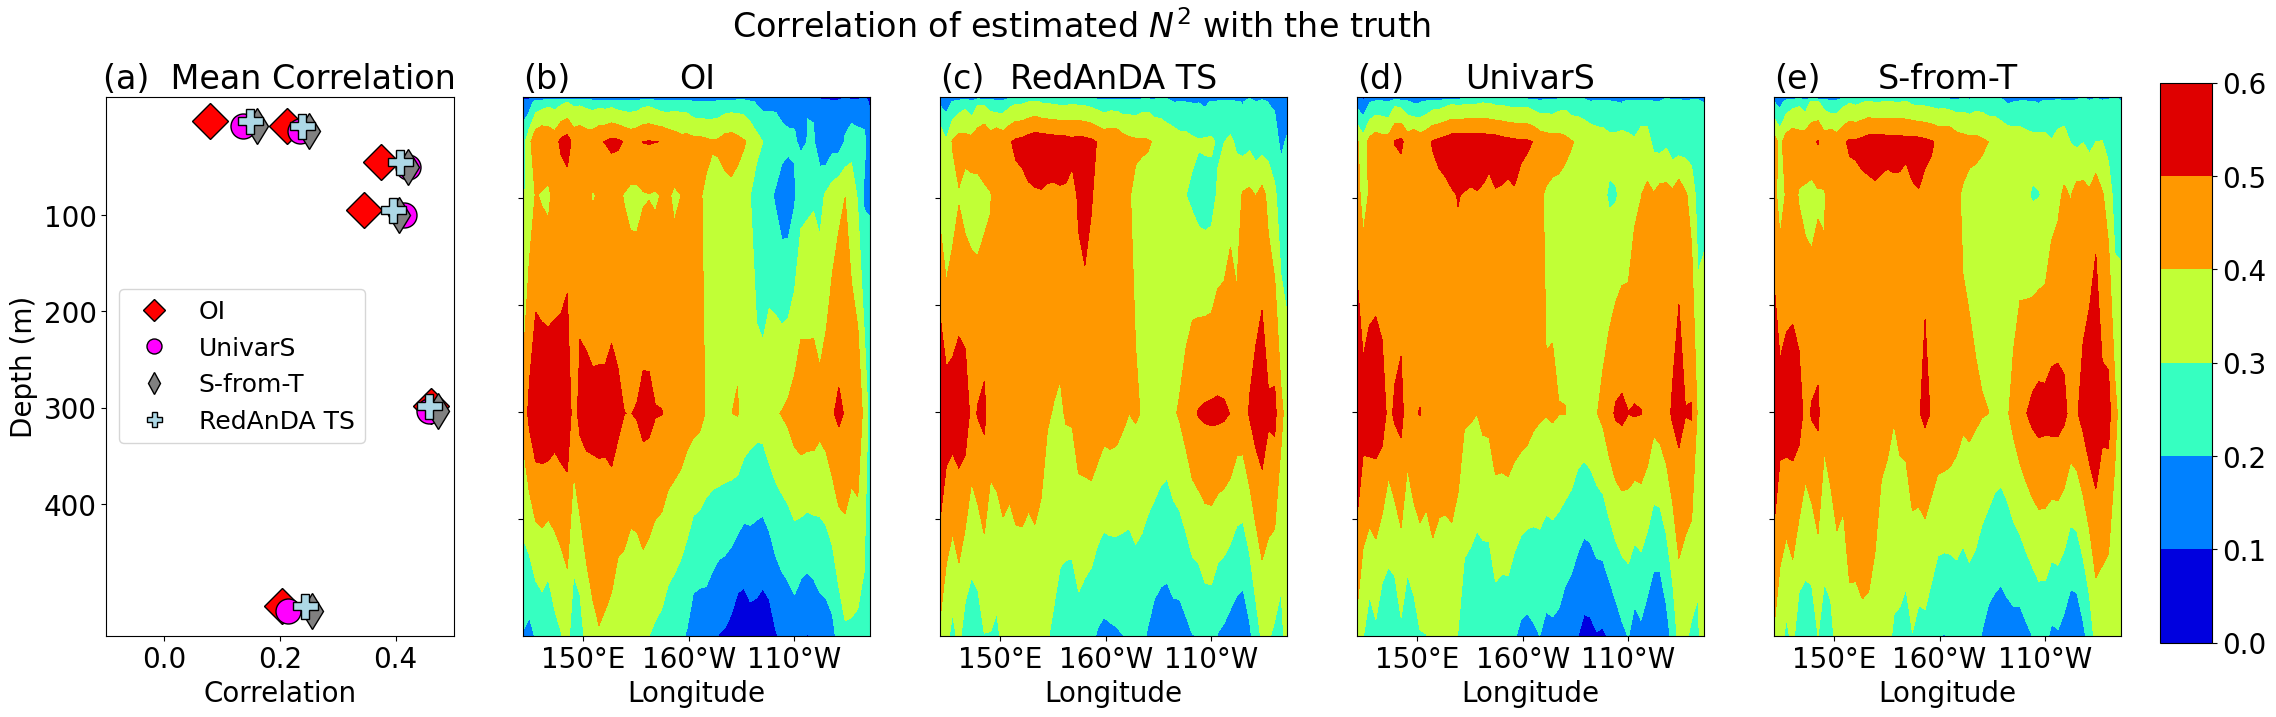

In [26]:
alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)']
alpind=0

g=9.81
N_AnDA =np.sqrt( Rho_AnDA2.differentiate('Depth') *g).swap_dims({'time':'JULD'}).rename({'JULD':'time'})#.sel(Lat=slice(-5,5))
N_RC2 =np.sqrt( Rho_RC2.differentiate('depth') *g)#.sel(latitude=slice(-5,5))
# N_TS4 =np.sqrt( -Rho_TS4.differentiate('depth') *g)
N_TS3 =np.sqrt( Rho_TS12.swap_dims({'depth':'Depth'}).differentiate('Depth') *g).swap_dims({'time':'JULD'}).rename({'JULD':'time'})#.sel(Lat=slice(-5,5))
# N_TS3 =np.sqrt( -xar.DataArray(Rho_TS3,dims=['time','depth','Lon','Lat'],coords={'JULD':(['time'],Rho_AnDA.JULD.values),'depth':(['depth'],RC.depth.values),'Lon':(['Lon'],Rho_AnDA.Lon.values),'Lat':(['Lat'],Rho_AnDA.Lat.values)}).differentiate('depth') *g).rename({'JULD':'time'})
N_OI = np.sqrt(Rho_OI.differentiate('depth') *g).swap_dims({'time':'JULD'}).rename({'JULD':'time'})#.sel(lat=slice(-5,5))
N_SfromT = np.sqrt(Rho_SfromT2.differentiate('depth') *g).drop('JULD').rename({"Lat":"latitude","Lon":"longitude"})#.sel(latitude=slice(-5,5))
# oicorr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_OI.groupby('time.month')-N_OI.groupby('time.month').mean()).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(N_OI.values.reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
# AnDAcorr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_AnDA.groupby('time.month')-N_AnDA.groupby('time.month').mean()).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(N_AnDA.values.reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
# TS3corr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_TS3.groupby('time.month')-N_TS3.groupby('time.month').mean()).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(np.moveaxis(N_TS3.values,-1,-2).reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
# SfromTcorr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_SfromT.groupby('time.month')-N_SfromT.groupby('time.month').mean()).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(np.moveaxis(N_SfromT.values,-1,-2).reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))


# oicorr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_OI.groupby('time.month')-N_OI.groupby('time.month').mean()).rename({'lat':'latitude','lon':'longitude'}).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(N_OI.values.reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
# AnDAcorr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_AnDA.groupby('time.month')-N_AnDA.groupby('time.month').mean()).rename({'Lat':'latitude','Lon':'longitude'}).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(N_AnDA.values.reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
# TS3corr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_TS3.groupby('time.month')-N_TS3.groupby('time.month').mean()).rename({'Lat':'latitude','Lon':'longitude'}).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(np.moveaxis(N_TS3.values,-1,-2).reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
# SfromTcorr = xar.corr((N_RC2.groupby('time2.month')-N_RC2.groupby('time2.month').mean())[-408:],(N_SfromT.groupby('time.month')-N_SfromT.groupby('time.month').mean()).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(np.moveaxis(N_SfromT.values,-1,-2).reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))

oicorr = xar.corr((N_RC2)[-408:],(N_OI).rename({'lat':'latitude','lon':'longitude'}).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(N_OI.values.reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
AnDAcorr = xar.corr((N_RC2)[-408:],(N_AnDA).rename({'Lat':'latitude','Lon':'longitude'}).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(N_AnDA.values.reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
TS3corr = xar.corr((N_RC2)[-408:],(N_TS3).rename({'Lat':'latitude','Lon':'longitude','Depth':'depth'}).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(np.moveaxis(N_TS3.values,-1,-2).reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))
SfromTcorr = xar.corr((N_RC2)[-408:],(N_SfromT).assign_coords({"time":N_RC2.time[-408:].values}),dim='time')#np.diag(np.corrcoef(np.moveaxis(N_SfromT.values,-1,-2).reshape((-1,408)),N_RC2[:,:,:,-408:].values.reshape((-1,408)))[4760:,:4760]).reshape((Ny,Nx,6))


matplotlib.rcParams.update({'font.size':20})
fig=plt.figure(figsize=(26,7))
ax=fig.add_subplot(1,5,1)
ax.plot(np.nanmean(oicorr,(2,1)).T,N_RC2['depth']-2.5,c='r',linestyle='',marker='D',markersize=18,label="OI",markeredgecolor='k')
ax.plot(np.nanmean(AnDAcorr,(2,1)).T,N_RC2['depth']+2.5,c='magenta',linestyle='',marker='o',markersize=18,label="UnivarS",markeredgecolor='k')
ax.plot(np.nanmean(SfromTcorr,(2,1)).T,N_RC2['depth']+2.5,c='gray',linestyle='',marker='d',markersize=18,label="S-from-T",markeredgecolor='k')
ax.plot(np.nanmean(TS3corr,(2,1)).T,N_RC2['depth']-2.5,c='lightblue',linestyle='',marker='P',markersize=18,label="RedAnDA TS",markeredgecolor='k')
ax.invert_yaxis()
plt.legend(fontsize=18,markerscale=.6,framealpha=.8)

ax.set_title(alphabet[alpind]+'  Mean Correlation',fontsize=24,)
alpind+=1
ax.set_yticks([100,200,300,400])
ax.set_yticklabels(['100','200','300','400'])
# ax.set_xticklabels([''])
# ax.set_xlim(-0.05,.48)
ax.set_xlabel('Correlation')
ax.set_ylabel('Depth (m)')

ax.set_xlim(-0.1,.5)
lvls=np.arange(0,.7,.1)


ax=fig.add_subplot(1,5,2)
ax.set_title(alphabet[alpind],loc='left')
alpind+=2

ctrf=ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(oicorr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
ax.invert_yaxis()
ax.set_title('OI',fontsize=24,)
ax.set_yticks([100,200,300,400])
ax.set_yticklabels(['','','',''])

ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')
ax.set_ylabel('')

ax=fig.add_subplot(1,5,4)
ax.set_title(alphabet[alpind],loc='left')
alpind-=1

ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(AnDAcorr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
ax.invert_yaxis()
ax.set_title('UnivarS',fontsize=24,)
ax.set_yticks([100,200,300,400])
ax.set_yticklabels(['','','',''])
ax.set_ylabel('')

ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')
ax=fig.add_subplot(1,5,3)
ax.set_title(alphabet[alpind],loc='left')
alpind+=2

ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(TS3corr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
ax.invert_yaxis()
ax.set_title('RedAnDA TS',fontsize=24,)
ax.set_yticks([100,200,300,400])
ax.set_yticklabels(['','','',''])
ax.set_ylabel('')



ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')
ax=fig.add_subplot(1,5,5)
ax.set_title(alphabet[alpind],loc='left')

ax.contourf(N_RC2.longitude,N_RC2['depth'],np.nanmean(SfromTcorr,(1)),cmap=plt.cm.jet,levels=lvls,add_colorbar=False)
ax.invert_yaxis()
ax.set_title('S-from-T',fontsize=24,)
ax.set_yticks([100,200,300,400])
ax.set_yticklabels(['','','',''])
ax.set_ylabel('')
ax.set_xlabel('')

plt.figtext(x=.5,y=.98,fontsize=24,s='Correlation of estimated $N^2$ with the truth',ha='center',va='center') 


plt.colorbar(ctrf,ticks=[0,.1,.2,.3,.4,.5,.6,],cax=plt.axes([.915,.1,.02,.8]))

# plt.colorbar(ctrf,ticks=[0,.2,.4,.6,.8,1],cax=plt.axes([.915,.1,.02,.8]))

ax.set_ylabel('')
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')

# plt.figtext(x=.5,y=.36,fontsize=24,s='Between 8-12°S',ha='center', va='center')

plt.savefig('../Article_SAL/Nsquare_Correlation_FullN2_OCCIPUT.png',bbox_inches='tight',dpi=300)

# GENERATE FIGURE 8

/tmp/ipykernel_2529645/522999098.py:24: RuntimeWarning: Mean of empty slice
  ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSSU_RC2.reshape((-1,12,Ny,Nx))-np.nanmean(OSSU_RC2.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=-0,vmax=0.4*vmaxx,extend='max',levels=np.arange(0,.4*vmaxx,.4*vmaxx/20),cmap=plt.cm.jet)
/tmp/ipykernel_2529645/522999098.py:25: RuntimeWarning: Mean of empty slice
  CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSSU_RC2[:],0),vmin=-.4*vmaxx2,vmax=0,extend='both',levels=np.arange(-.4*vmaxx2,0,.4*vmaxx2/4),colors='k',linestyles=[':','-.','--','-'][::-1])
/tmp/ipykernel_2529645/522999098.py:42: RuntimeWarning: Mean of empty slice
  ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSS_RC2.reshape((-1,12,Ny,Nx))-np.nanmean(OSS_RC2.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=-0,vmax=vmaxx,extend='max',levels=np.arange(0,vmaxx,vmaxx/20),cmap=plt.cm.jet)
/tmp

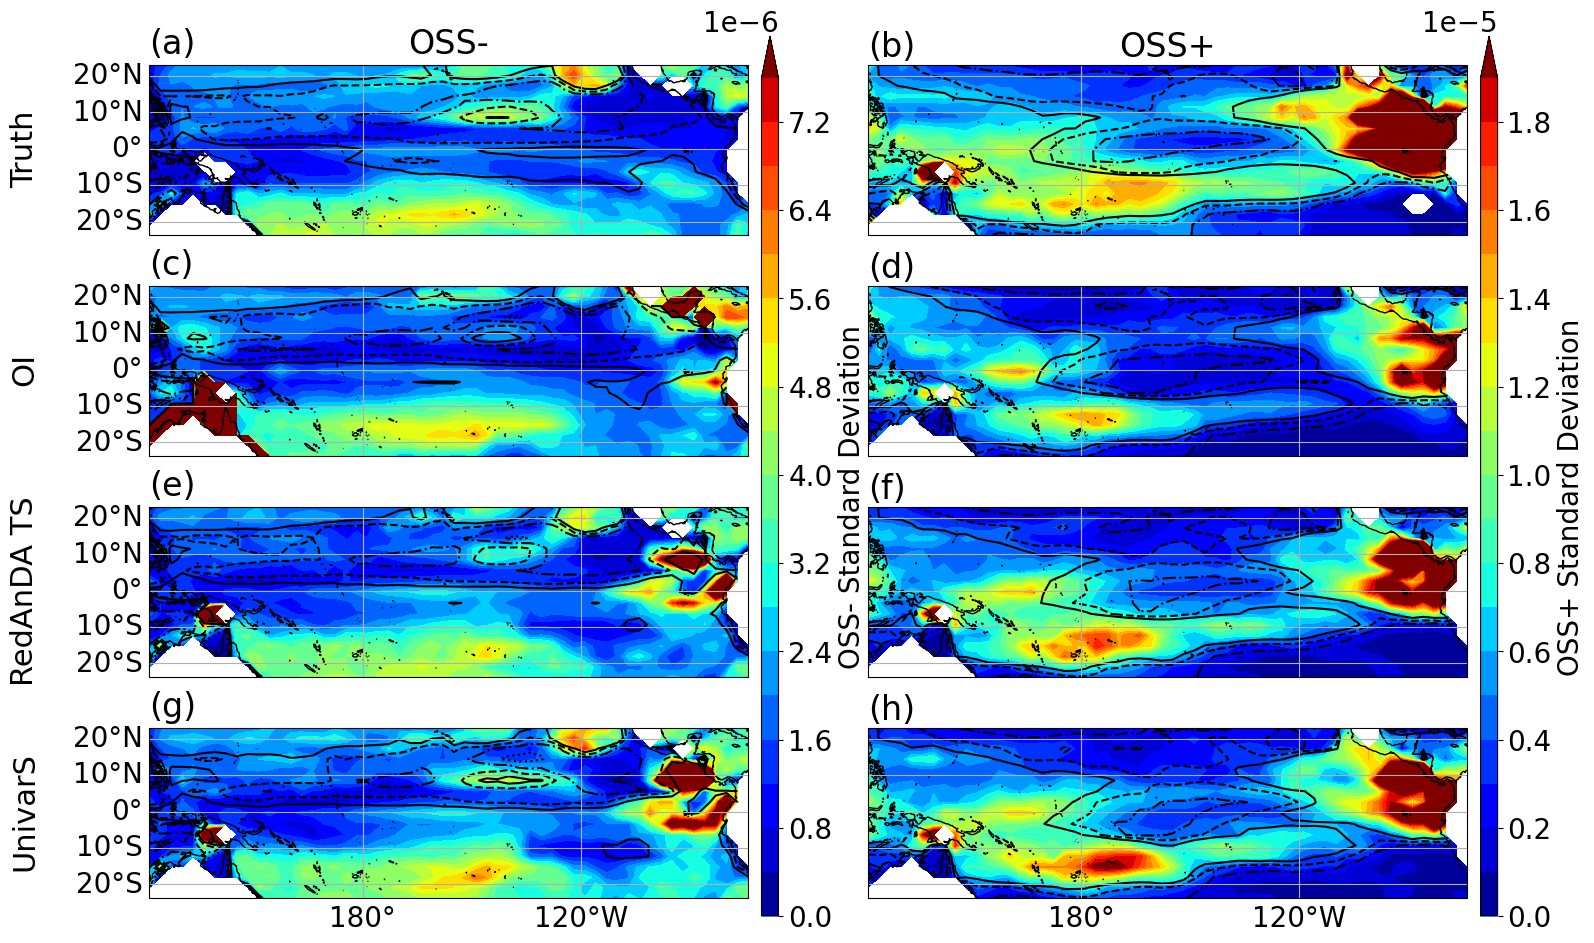

In [27]:
fig=plt.figure(figsize=(17,11))
import matplotlib.ticker as ticker

alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)']
alpind=0
ax=fig.add_subplot(4,2,1,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1


def func(x):
    s = "%.0g" % x
    if "e" in s:
        tup = s.split('e')
        significand = tup[0].rstrip('0').rstrip('.')
        sign = tup[1][0].replace('+', '')
        exponent = tup[1][1:].lstrip('0')
        s = ('%se%s%s' % (significand, sign, exponent)).rstrip('e')    
    return s


vmaxx=2e-5
vmaxx2=2e-5
ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSSU_RC2.reshape((-1,12,Ny,Nx))-np.nanmean(OSSU_RC2.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=-0,vmax=0.4*vmaxx,extend='max',levels=np.arange(0,.4*vmaxx,.4*vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSSU_RC2[:],0),vmin=-.4*vmaxx2,vmax=0,extend='both',levels=np.arange(-.4*vmaxx2,0,.4*vmaxx2/4),colors='k',linestyles=[':','-.','--','-'][::-1])
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
ax.set_title('OSS-')
ax.text(x=-97,y=0,s='Truth',fontsize=22,rotation='vertical',va='center')
ax=fig.add_subplot(4,2,2,projection=PlateCarree(central_longitude=180))
ax.set_title('OSS+')
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1


# ax.set_title('From 1980 to 2000')
ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSS_RC2.reshape((-1,12,Ny,Nx))-np.nanmean(OSS_RC2.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=-0,vmax=vmaxx,extend='max',levels=np.arange(0,vmaxx,vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSS_RC2[:],0),vmin=0,vmax=vmaxx2,extend='both',levels=np.arange(0,vmaxx2,vmaxx2/4),colors='k',linestyles=[':','-.','--','-'])

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
grdl.left_labels=False


ax=fig.add_subplot(4,2,3,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1



ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSSU_OI.reshape((-1,12,Ny,Nx))-np.nanmean(OSSU_OI.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=0,vmax=0.4*vmaxx,extend='max',levels=np.arange(0,.4*vmaxx,.4*vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSSU_OI[:],0),vmin=-.4*vmaxx2,vmax=0,extend='both',levels=np.arange(-.4*vmaxx2,0,.4*vmaxx2/4),colors='k',linestyles=[':','-.','--','-'][::-1])
# ax.clabel(CS,CS.levels, fmt=func,inline=True,  fontsize=18)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
ax.text(x=-97,y=0,s='OI',fontsize=22,rotation='vertical',va='center')
ax=fig.add_subplot(4,2,4,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1

ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSS_OI.reshape((-1,12,Ny,Nx))-np.nanmean(OSS_OI.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=0,vmax=vmaxx,extend='max',levels=np.arange(0,vmaxx,vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSS_OI[:],0),vmin=0,vmax=vmaxx2,extend='both',levels=np.arange(0,vmaxx2,vmaxx2/4),colors='k',linestyles=[':','-.','--','-'])
# ax.clabel(CS,CS.levels, fmt=func,inline=True,  fontsize=18)

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
grdl.left_labels=False


ax=fig.add_subplot(4,2,5,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1

ax.text(x=-97,y=0,s='RedAnDA TS',fontsize=22,rotation='vertical',va='center')
ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSSU_TS12.reshape((-1,12,Ny,Nx))-np.nanmean(OSSU_TS12.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=0,vmax=0.4*vmaxx,extend='max',levels=np.arange(0,.4*vmaxx,.4*vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSSU_TS12[:],0),vmin=-.4*vmaxx2,vmax=0,extend='both',levels=np.arange(-.4*vmaxx2,0,.4*vmaxx2/4),colors='k',linestyles=[':','-.','--','-'][::-1])
# ax.clabel(CS,CS.levels, fmt=func,inline=True,  fontsize=18)
# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
ax=fig.add_subplot(4,2,6,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1

ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSS_TS12.reshape((-1,12,Ny,Nx))-np.nanmean(OSS_TS12.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=0,vmax=vmaxx,extend='max',levels=np.arange(0,vmaxx,vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSS_TS12[:],0),vmin=0,vmax=vmaxx2,extend='both',levels=np.arange(0,vmaxx2,vmaxx2/4),colors='k',linestyles=[':','-.','--','-'])
# ax.clabel(CS,CS.levels, fmt=func,inline=True,  fontsize=18)

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.left_labels=False
grdl.bottom_labels=False


ax=fig.add_subplot(4,2,7,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1


ax.text(x=-97,y=0,s='UnivarS',fontsize=22,rotation='vertical',va='center')
ctrt=ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSSU_AnDA2.reshape((-1,12,Ny,Nx))-np.nanmean(OSSU_AnDA2.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=0,vmax=0.4*vmaxx,extend='max',levels=np.arange(0,.4*vmaxx,.4*vmaxx/20),cmap=plt.cm.jet)

plt.colorbar(ctrt,cax=plt.axes([.485,.1,.01,.8]),label='OSS- Standard Deviation')
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSSU_AnDA2[:],0),vmin=-.4*vmaxx2,vmax=0,extend='both',levels=np.arange(-.4*vmaxx2,0,.4*vmaxx2/4),colors='k',linestyles=[':','-.','--','-'][::-1])
# fmt = ticker.SciNotation()
# ax.clabel(CS,CS.levels, fmt=func, fontsize=14)
# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False

ax=fig.add_subplot(4,2,8,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1

ctrt=ax.contourf( RC['longitude']+180, RC['latitude'],np.sqrt(np.nanmean((OSS_AnDA2.reshape((-1,12,Ny,Nx))-np.nanmean(OSS_AnDA2.reshape((-1,12,Ny,Nx)),0)[np.newaxis]).reshape((-1,Ny,Nx))[:]**2,0)),vmin=0,vmax=vmaxx,extend='max',levels=np.arange(0,vmaxx,vmaxx/20),cmap=plt.cm.jet)
CS=ax.contour( RC['longitude']+180, RC['latitude'],np.nanmean(OSS_AnDA2[:],0),vmin=0,vmax=vmaxx2,extend='both',levels=np.arange(0,vmaxx2,vmaxx2/4),colors='k',linestyles=[':','-.','--','-'])
# ax.clabel(CS,CS.levels, fmt=func, fontsize=14)

plt.colorbar(ctrt,cax=plt.axes([.908,.1,.01,.8]),label='OSS+ Standard Deviation')
# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.left_labels=False

# plt.savefig('Article_SAL/OCCIPUT_OSS&OSSU.png',dpi=300)
plt.savefig('../Article_SAL/OCCIPUT_OSS&OSSU_TS12.png',dpi=300)